In [1]:
# 패키지 불러오기
import pandas as pd  # pandas
import numpy as np   # numpy
import matplotlib.pyplot as plt  # matplotlib.pyplot
%matplotlib inline
# 한글 설정
from matplotlib import font_manager, rc   
plt.rcParams['axes.unicode_minus'] = False   # 그래프 한글 설정을 위해 matplotlib에서 rc 불러오기 (한글 깨짐 현상을 막아줌)

import platform
if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

import seaborn as sns # seaborn
import datetime  # datetime
from sklearn.preprocessing import LabelEncoder # sklearn.LabelEncoder
from xgboost.sklearn import XGBClassifier  # xgboost
import warnings   # warning ignore
warnings.filterwarnings('ignore')

### 1. Data Preprocessing

In [2]:
# 데이터 불러오기 - train, test 데이터, 각각의 데이터 크기 조회
df_train = pd.read_csv("datas2/train_users_2.csv")
df_test = pd.read_csv("datas2/test_users.csv")
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

- train 데이터 213,451개 row, 16개 column / test 데이터 62,096개 row, 15개 column

In [3]:
# train 데이터 확인 
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
# test 데이터 확인 
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


 - column명칭 및 정보 
    - id : 유저
    - date_account_created : 계정 만든 날
    - timestamp_first_active : 타임스탬프 최초 활성화 : 첫 번째 활동의 타임 스탬프, 사용자가 가입하기 전에 검색 할 수 있으므로 date_account_created 또는 date_first_booking보다 빠를 수 있습니다.
    - date_first_booking : 첫 예약일 
    - gender : 성별 
    - age : 연령
    - signup_method : 가입 방법
    - signup_flow : 사용자가 가입 한 페이지
    - language : 언어
    - affiliate_channel : 제휴 채널 
    - affiliate_provider : 제휴 제공자
    - first_affiliate_tracked : 첫번째 제휴사 추적 : 가입하기 전에 사용자가 처음으로 상호 작용 한 마케팅 내용
    - signup_app : 로그인 어플리케이션 
    - first_device_type : 첫번째 디바이스 타입
    - first_browser : 첫번째 브라우져 타입 
    - country_destination : 목적지 국가 

In [6]:
# 테스트 데이터 id 살펴보기 
id_test = df_test.id
id_test

0        5uwns89zht
1        jtl0dijy2j
2        xx0ulgorjt
3        6c6puo6ix0
4        czqhjk3yfe
            ...    
62091    cv0na2lf5a
62092    zp8xfonng8
62093    fa6260ziny
62094    87k0fy4ugm
62095    9uqfg8txu3
Name: id, Length: 62096, dtype: object

In [7]:
# train 데이터에 country_destination 컬럼 삭제 (EDA를 위해 test 데이터와 합치기 위한 전처리)
df_train.drop(['country_destination'], axis=1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari


In [8]:
# EDA를 위해 train과 test 데이터 합치기
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all.shape

(275547, 16)

In [9]:
# 데이터 확인 - 총 row값 275,547, column값 16개 
df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [10]:
# 각 컬럼마다 결측치가 얼마나 있는지 찾기
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + "has {} null values.".format(ab))
        print()

date_first_bookinghas 186639 null values.

agehas 116866 null values.

first_affiliate_trackedhas 6085 null values.

country_destinationhas 62096 null values.



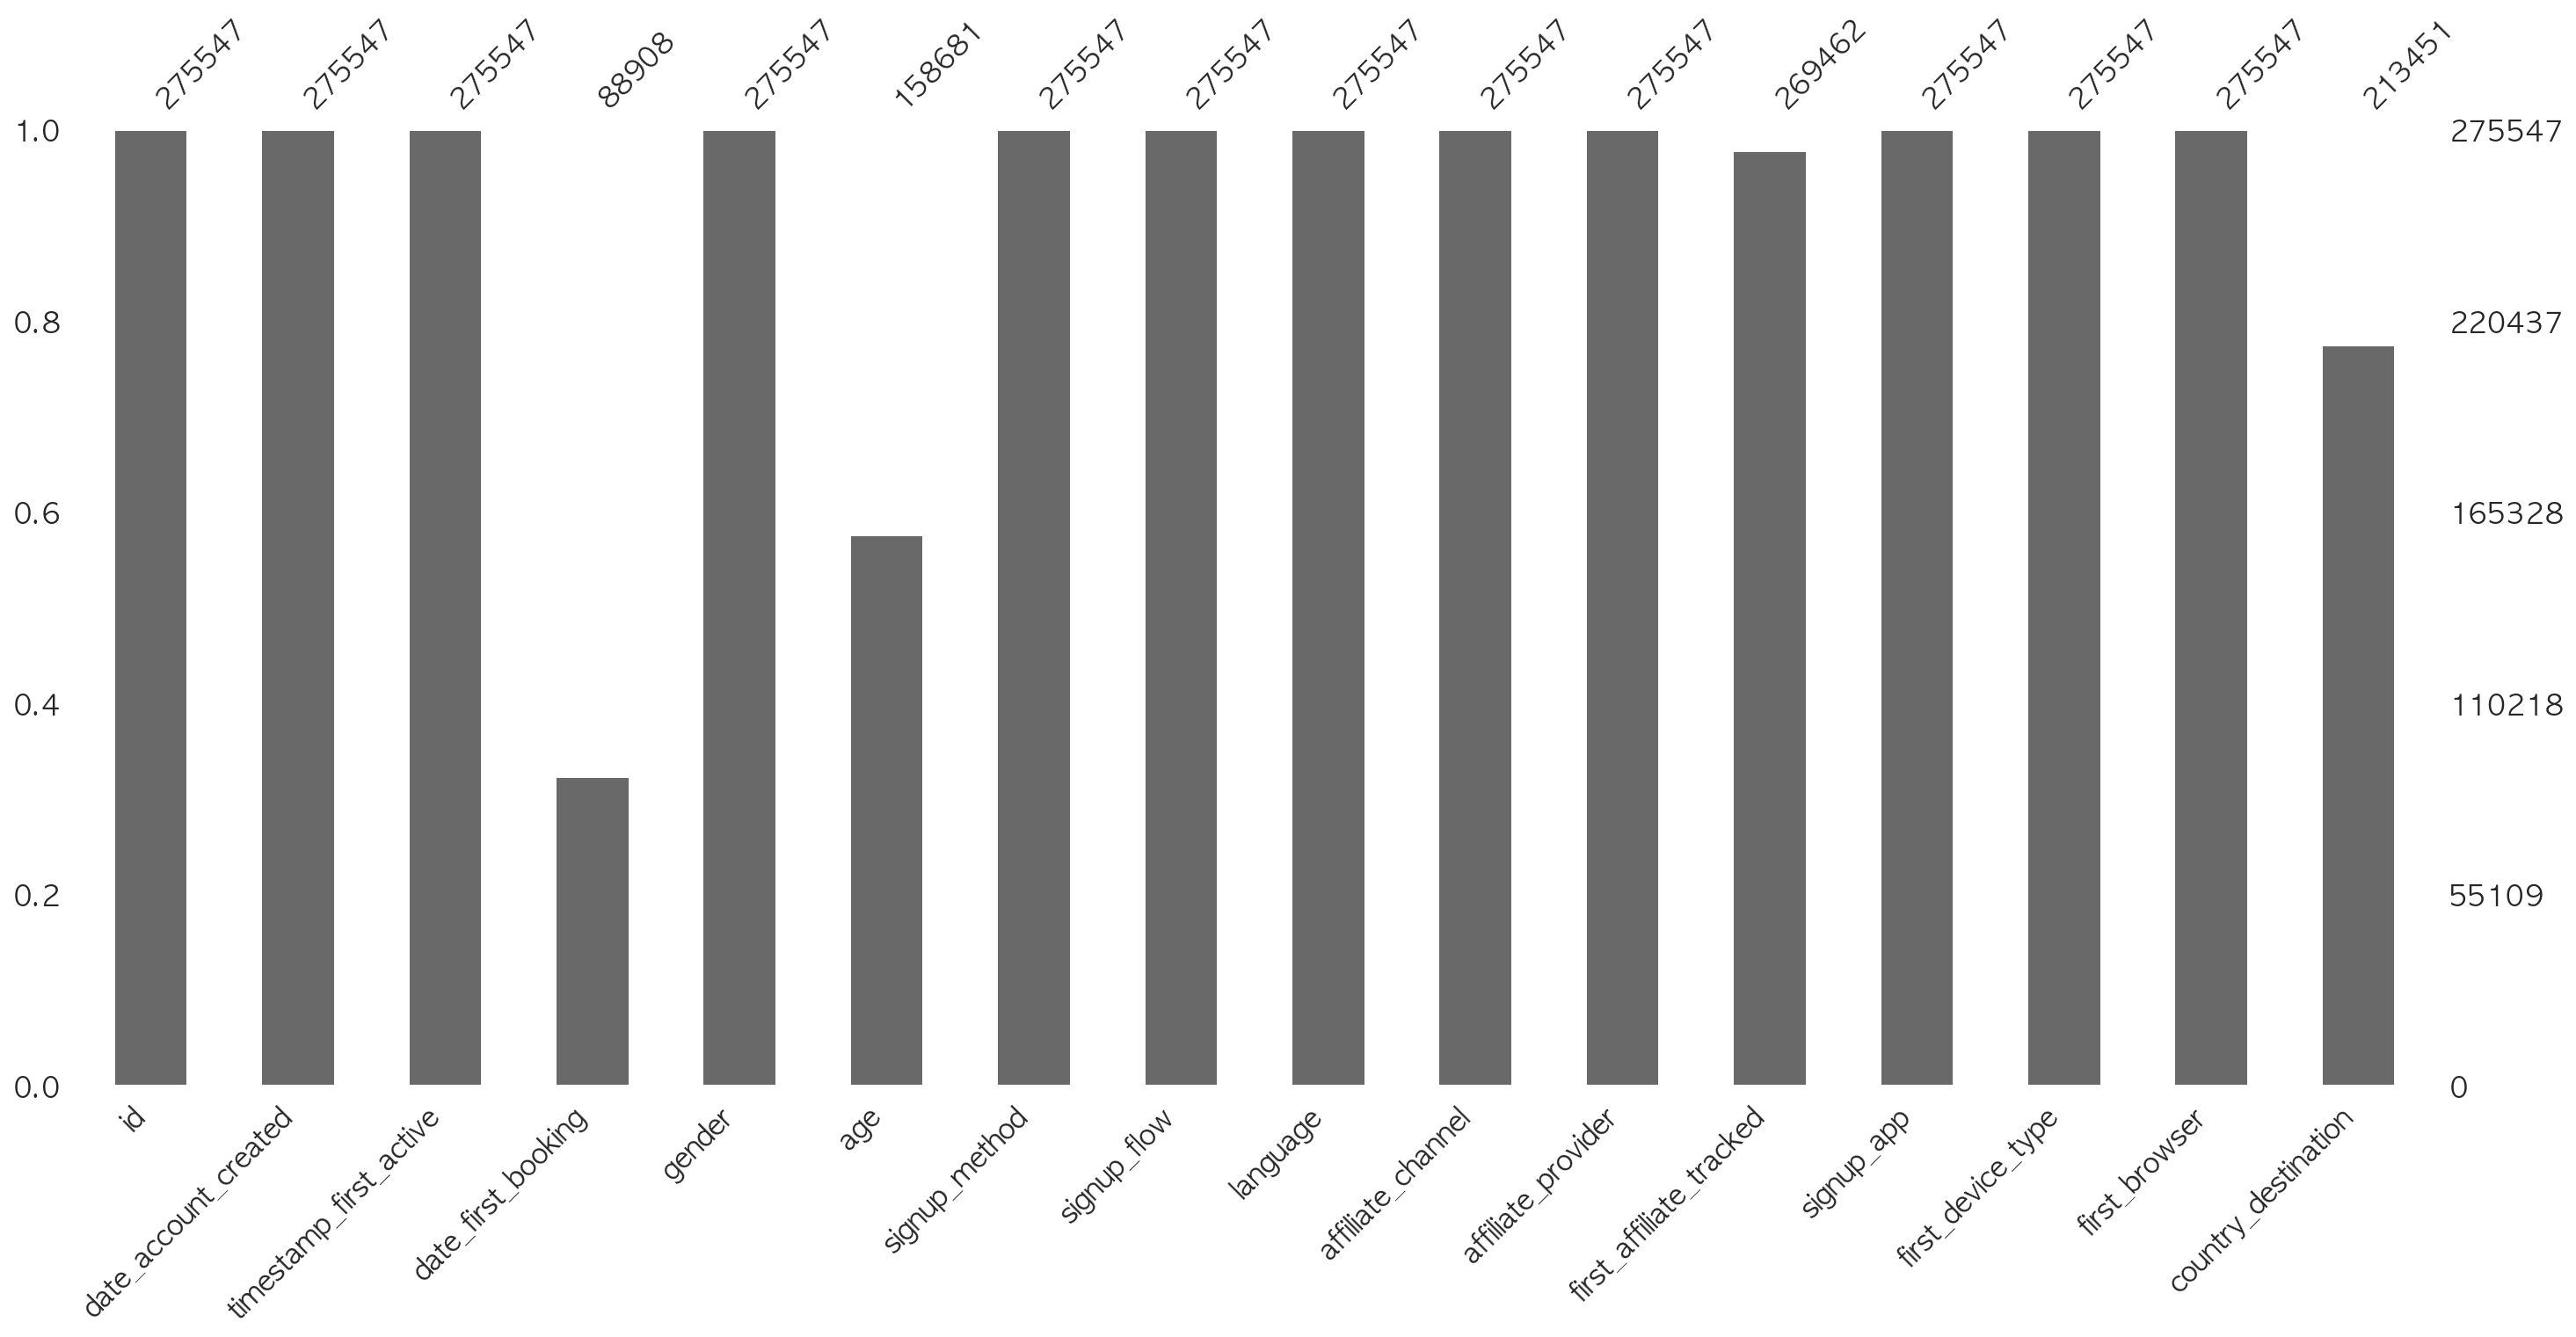

In [11]:
import missingno as msno
msno.bar(df_all)
plt.show()

In [12]:
# 데이터 확인
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [13]:
# 성별 데이터 확인 
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [14]:
# 연령대 현황 살펴보기 - 수치가 뒤죽박죽
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [15]:
# 15 보다 작고, 100보다 큰 값들 모두 nan 값으로 처리
df_all[df_all['age']<15].age = np.nan
df_all[df_all['age']>=100].age = np.nan

In [18]:
# 아래 열을 그래프로 표시하기 위해 범주로 변환
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

# 범주형 데이터를 category로 변경한 이유는 메모리 사용량이 줄어들어 처리속도를 올리기 위해서 이다.
for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

In [19]:
# date_account_created와 timestamp_first_active를 데이트 타입 형식으로 전환 
df_all["date_account_created"] = pd.to_datetime(df_all["date_account_created"])
df_all["timestamp_first_active"] = pd.to_datetime(df_all["timestamp_first_active"], 
                                                  format='%Y%m%d%H%M%S') # 년,월,일,시간,분,초 형식으로 전환 

### 2. Visualization

In [20]:
# 한글 설정
from matplotlib import font_manager, rc   
plt.rcParams['axes.unicode_minus'] = False   # 그래프 한글 설정을 위해 matplotlib에서 rc 불러오기 (한글 깨짐 현상을 막아줌)

import platform
if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

sns.set_style('darkgrid') # seaborn 그래프 background 회색으로 설정 
sns.set_context('talk') # 컨텍스트 매개 변수를 변경 플롯의 레이블에 대한 기본 글꼴 크기를 제어하는데 사용
sns.set(font_scale = 1)

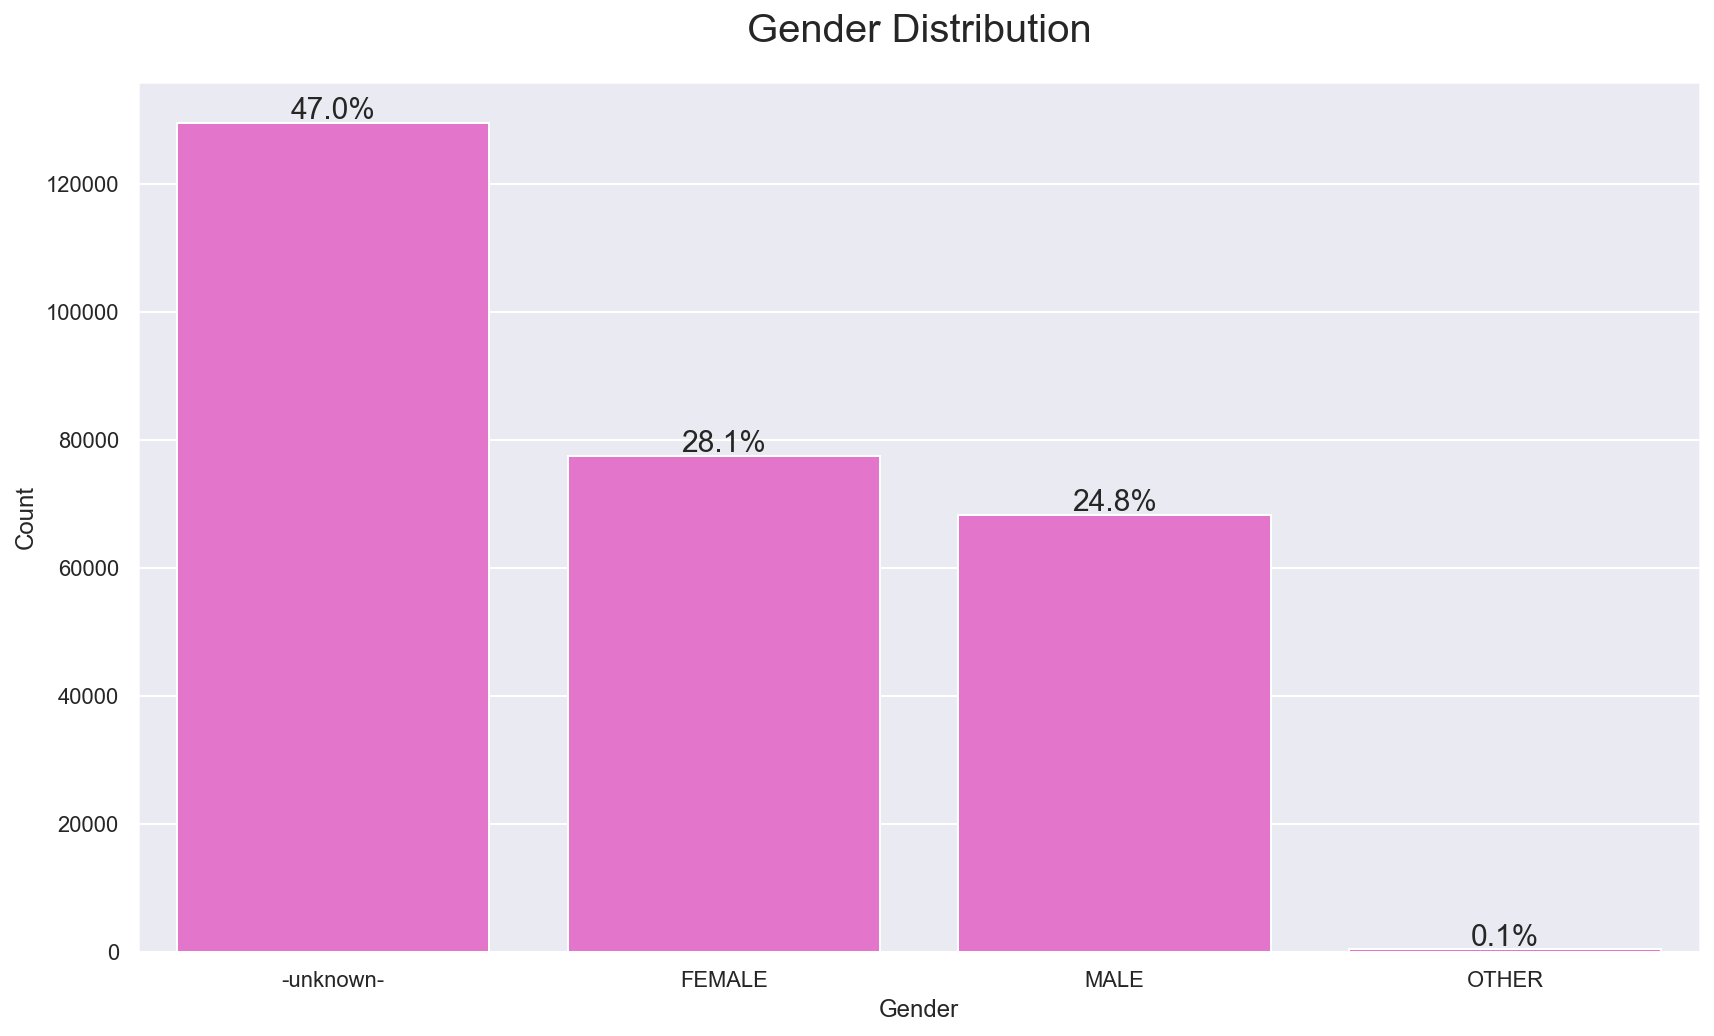

In [21]:
# 성별 분포
plt.figure(figsize=(14,8))
order1 = df_all['gender'].value_counts().index
sns.countplot(data = df_all, x='gender', order = order1, color=sns.color_palette("husl", 9)[8])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title("Gender Distribution",  fontsize = 20, pad=20)
order2 = df_all['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt = "{:0.1f}%".format(100*count / df_all.shape[0])
    plt.text(i, count+700, strt, ha = "center", fontsize=15)

- 성별 분포는 알수없음 47.0% / 여성 28.1% / 남성 24.8% / ohter 0.1%로 알수없음을 제외하면 여성의 비중이 높다.

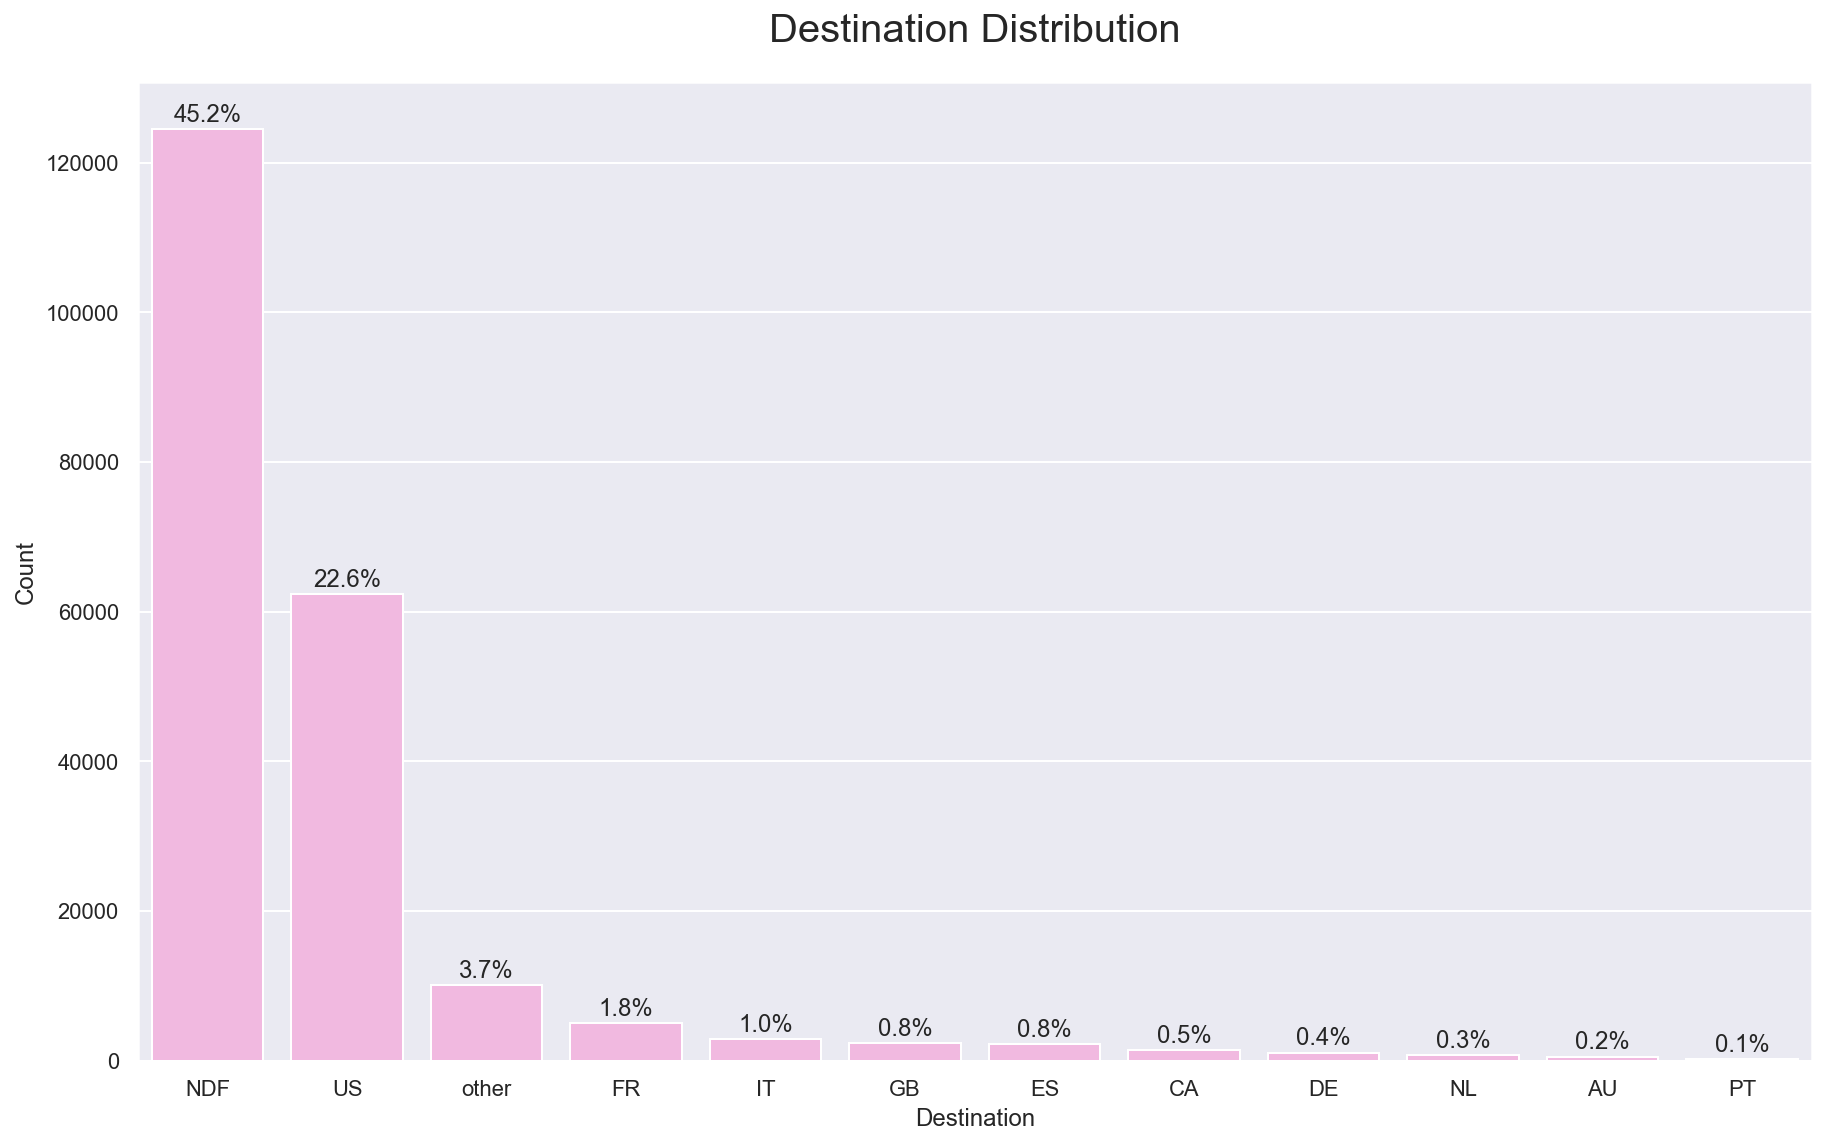

In [22]:
# 목적지 분포
plt.figure(figsize=(15,9))
order1 = df_all['country_destination'].value_counts().index
sns.countplot(data = df_all, x='country_destination', order = order1, color=sns.color_palette("pastel")[6])
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title("Destination Distribution", fontsize=20, pad=20)
order2 = df_all['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt = "{:0.1f}%".format(100*count / df_all.shape[0])
    plt.text(i, count+1000, strt, ha = "center")

- 목적지 분포는 NDF(한번도 예약하지 않음)의 비율이 45.2%로 가장 많고, 그 다음으로 22.6%로 미국이 많았다. (참고로 해당 가입자들은 미국인 기준이다.)

In [23]:
from pyecharts import Pie
provider = pd.DataFrame(df_all['affiliate_provider'].value_counts())

keys = list(provider["affiliate_provider"].keys())
values = list(provider["affiliate_provider"].values)

pie = Pie("Affiliate Provider Distribution")
pie.add("", keys, values, is_randome=True, center=[45,50], radius=[40, 80], 
        is_legend_show=False, is_label_show=True)

pie

- 제휴 제공자 분포는 다이렉트로 airbnb 사이트에 가입한 비율이 65.79% /google로 가입한 비율이 23.94%로 해당 사이트의 비율이 가장 높다.

In [24]:
# date_account_create에 있는 자료 중 년도만 추출 

df_all['acc_year'] = df_all['date_account_created'].dt.year

# acc 컬럼을 count 기준으로 groupby
df1 = df_all.groupby('acc_year').count()

years = [2010, 2011, 2012, 2013, 2014]
yearOrder = pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace=True)
df1.acc_year = df1.acc_year.astype(yearOrder)

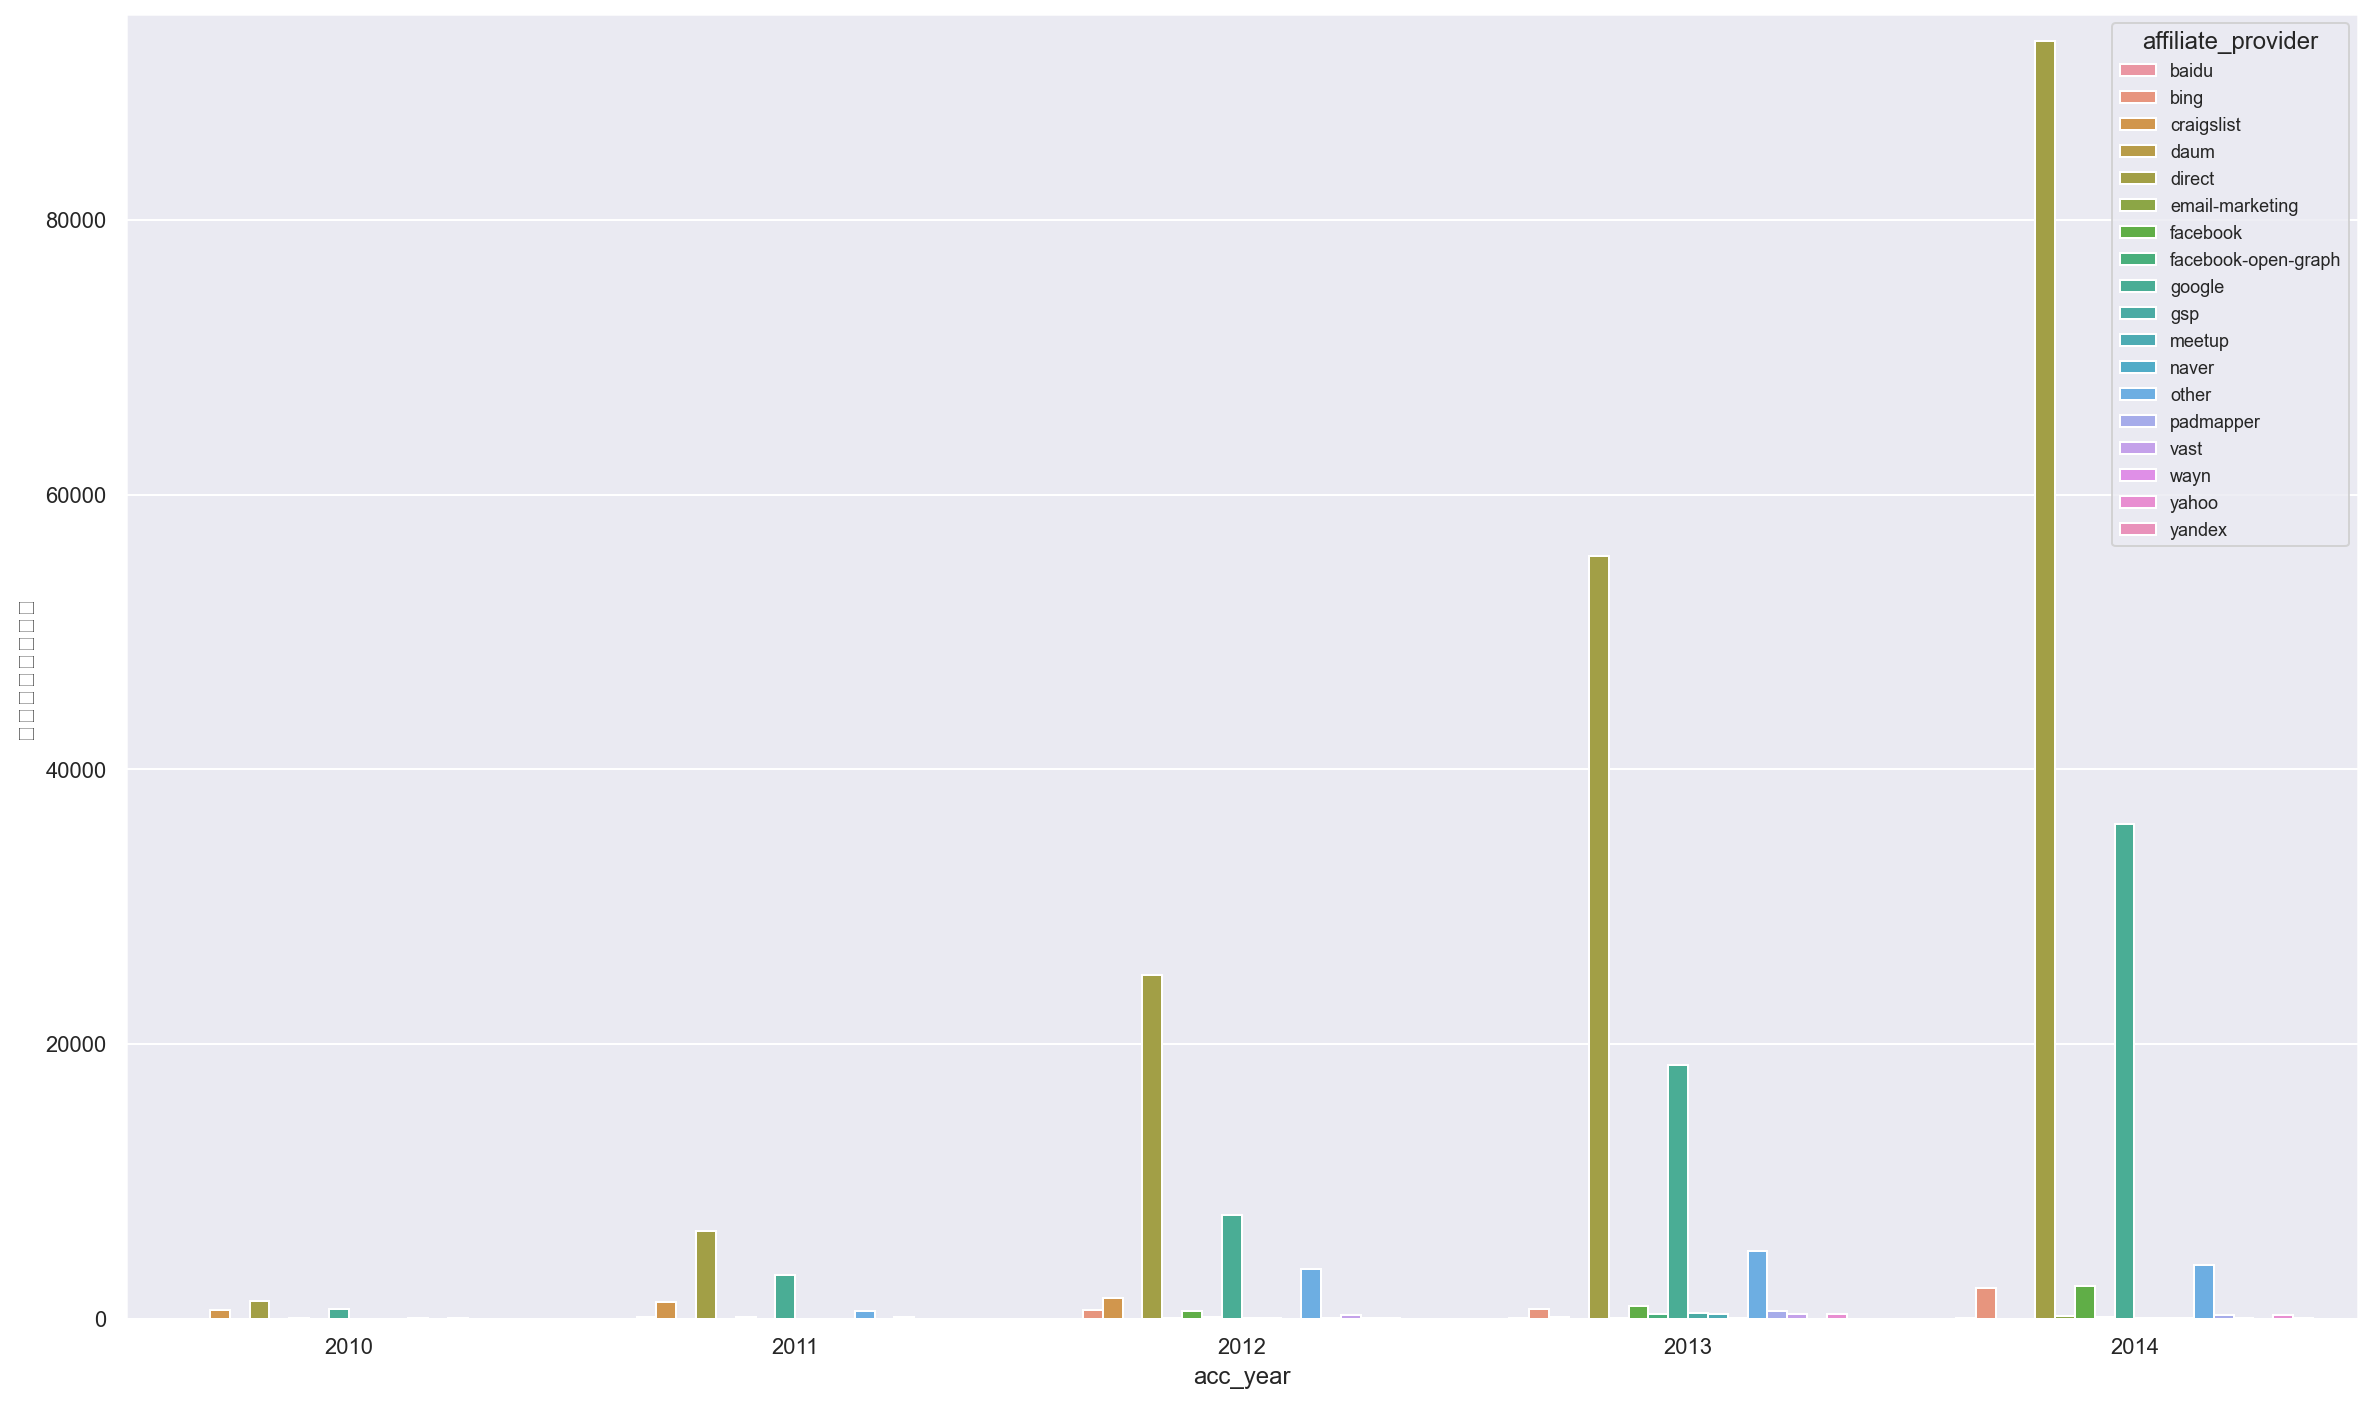

In [25]:
# 연도별 제휴 제공처
df_all_year = pd.DataFrame(df_all.groupby(by=['acc_year', 
                                              'affiliate_provider'])['affiliate_provider'].count())
df_all_year.columns = ['제휴제공자분포수']

# 멀티 인덱스 제거
df_all_year.reset_index(level=["affiliate_provider"], inplace=True)

# 제휴제공처 연도별 비교
plt.figure(figsize=(20,12)) # 차트사이즈
plt.rc('legend', fontsize=9) # 범례 사이즈
plt.ylim(0, 95000)
plt.rc('axes', labelsize=20) # 축 제목
plt.rc('font', size=20) # x,y 축 값
# plt.xticks(fontsize=20, rotation=0) # x축 값

sns.barplot(data=df_all_year, x=df_all_year.index, y='제휴제공자분포수', hue='affiliate_provider')
plt.show()

- 년도 별 기준으로 제휴제공자 분포를 살펴 보면 위와 같이 airbnb 사이트와 google로 가입하는 비율이 매년마다 증가함을 알 수있다.

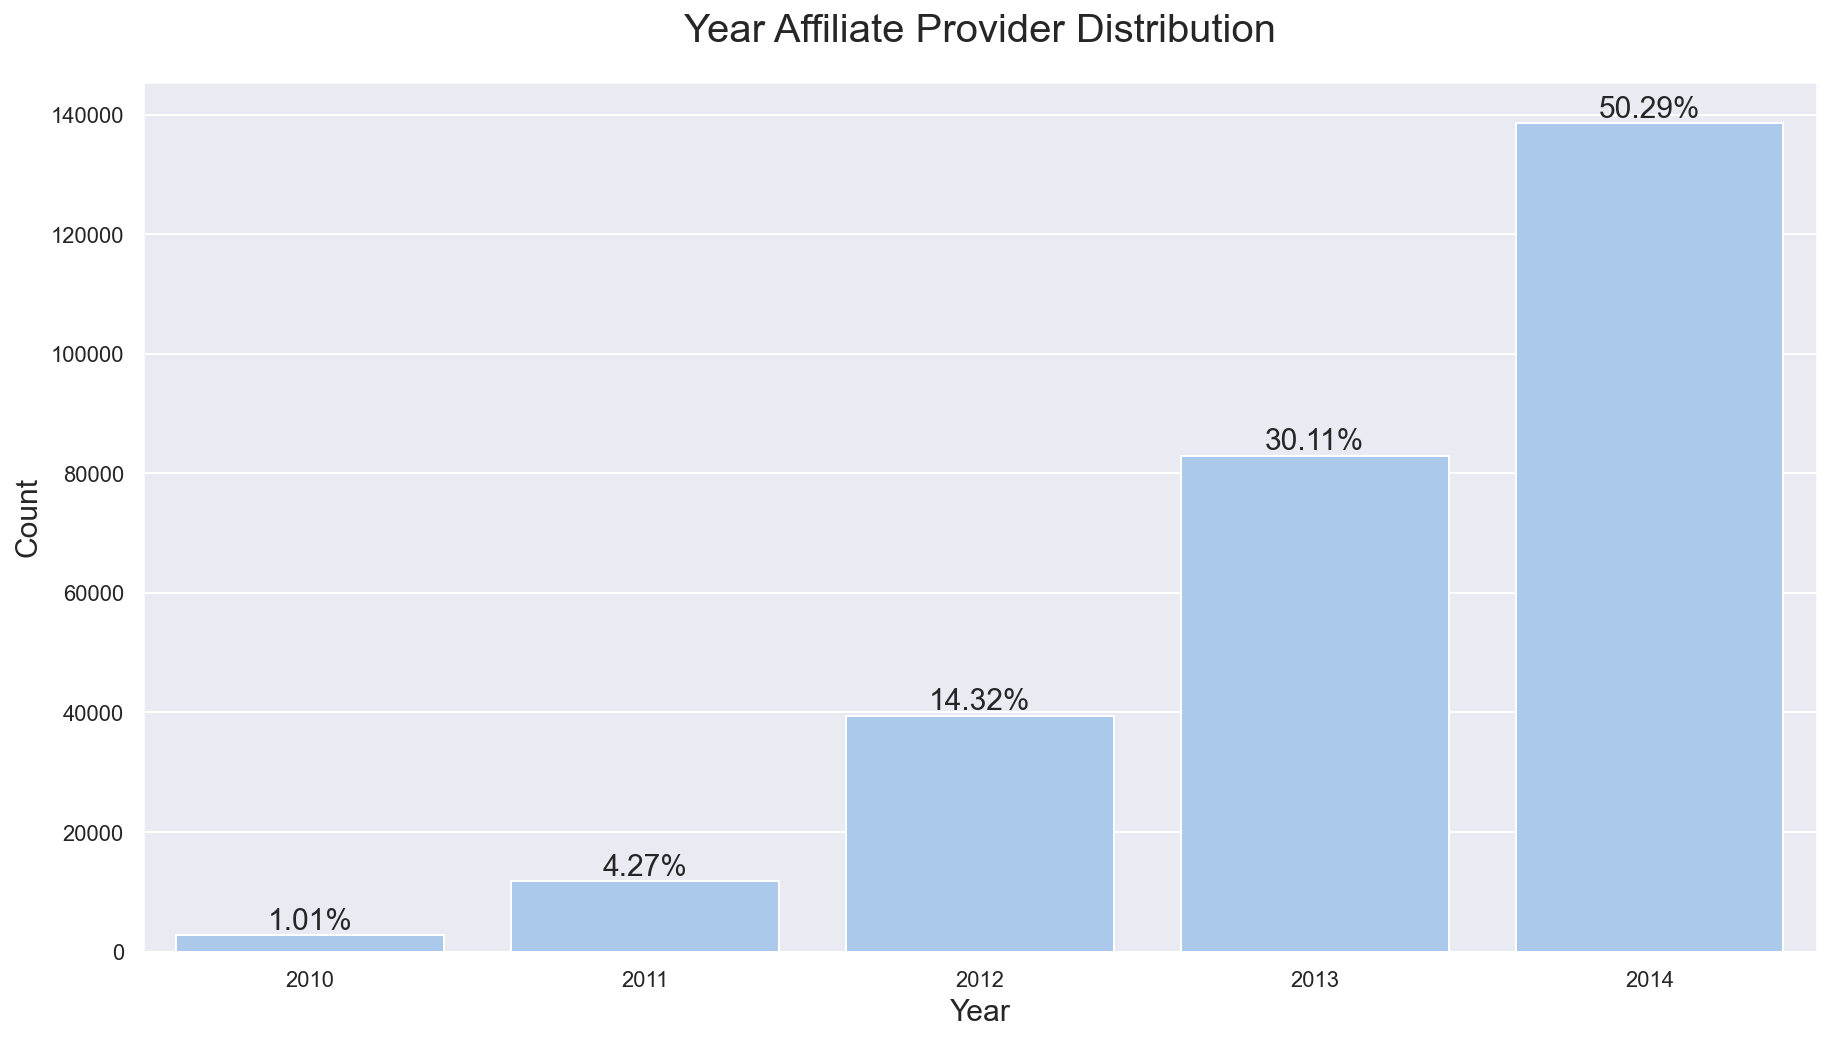

In [26]:
# 제휴처 사용량을 기준 그래프
plt.figure(figsize=[15,8])
sns.barplot(data = df1, x='acc_year', y="affiliate_provider", color=sns.color_palette("pastel")[0])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Year Affiliate Provider Distribution", fontsize=20, pad=20)
for i in range(df1.shape[0]):
    count = df1.iloc[i]["affiliate_provider"]
    strt = "{:0.2f}%".format(100*count / df_all.shape[0])
    plt.text(i, count+1000, strt, ha = "center", fontsize=15)

- 제휴제공처를 전체로 합쳐 매년 기준으로 본 결과 꾸준히 증가함을 알 수 있다.

In [27]:
# 2014년도 월별 제휴 제공자 데이터를 알아보기 위해 데이터프레임 추가
df2 = df_all[df_all["date_account_created"].dt.year == 2014]
df2['monthyear14'] = df2["date_account_created"].map(lambda x: x.strftime("%Y-%m"))
df2 = df2.groupby('monthyear14').count()

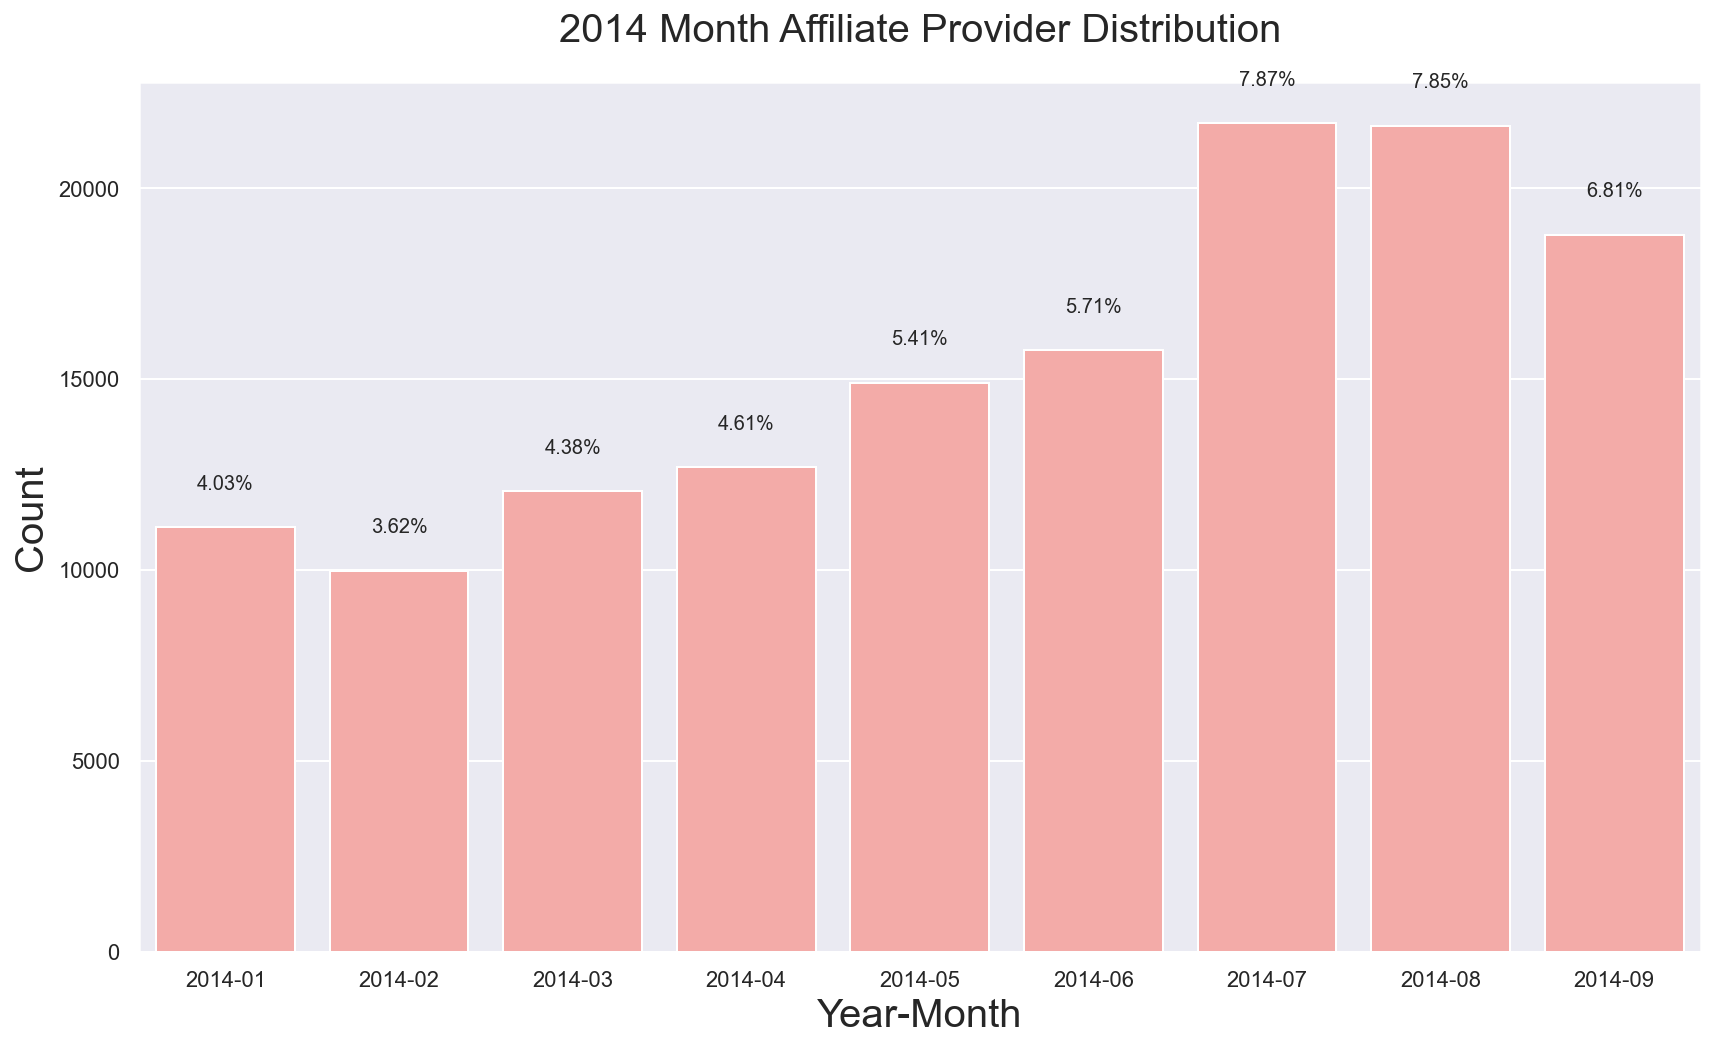

In [28]:
# 2014년 월별 제휴처 사용량을 기준 그래프
plt.figure(figsize=[14,8])
sns.barplot(data=df2, x=df2.index, y="affiliate_provider", color=sns.color_palette("pastel")[3])
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title("2014 Month Affiliate Provider Distribution", fontsize=20, pad=20);
for i in range(df2.shape[0]):
    count = df2.iloc[i]["affiliate_provider"]
    strt = "{:0.2f}%".format(100*count / df_all.shape[0])
    plt.text(i, count+1000, strt, ha = "center", fontsize=10)

- 분포가 가장 높은 2014년도의 매달 기준으로 분포를 본 결과 4월 부터 7월까지 증가하다 8월부터 이용이 줄어든다. 성수기 비성수기에 따라 증가와 감소가 이루어지지 않았을까? 조심히 예측해본다.

In [29]:
# 회원 연령 나누기 
df_all['member_age_bins'] = df_all['age'].apply(lambda x: '18-20' if 18<x<=20
                                               else '20-30' if 20<x<=30
                                               else '30-40' if 30<x<=40
                                               else '40-50' if 40<x<=50
                                               else '50-60' if 50<x<=60
                                               else '60-70' if 60<x<=70
                                               else '70+' if 70<x<=100
                                               else np.nan)

In [30]:
df_all['member_age_bins']

0           NaN
1         30-40
2         50-60
3         40-50
4         40-50
          ...  
275542    30-40
275543      NaN
275544      NaN
275545      NaN
275546    40-50
Name: member_age_bins, Length: 275547, dtype: object

In [31]:
# 2013년도 월별 제휴 제공자 데이터를 알아보기 위해 데이터프레임 추가
df3 = df_all[df_all["date_account_created"].dt.year == 2013]
df3['monthyear13'] = df3["date_account_created"].map(lambda x: x.strftime("%Y-%m"))
df3 = df3.groupby('monthyear13').count()

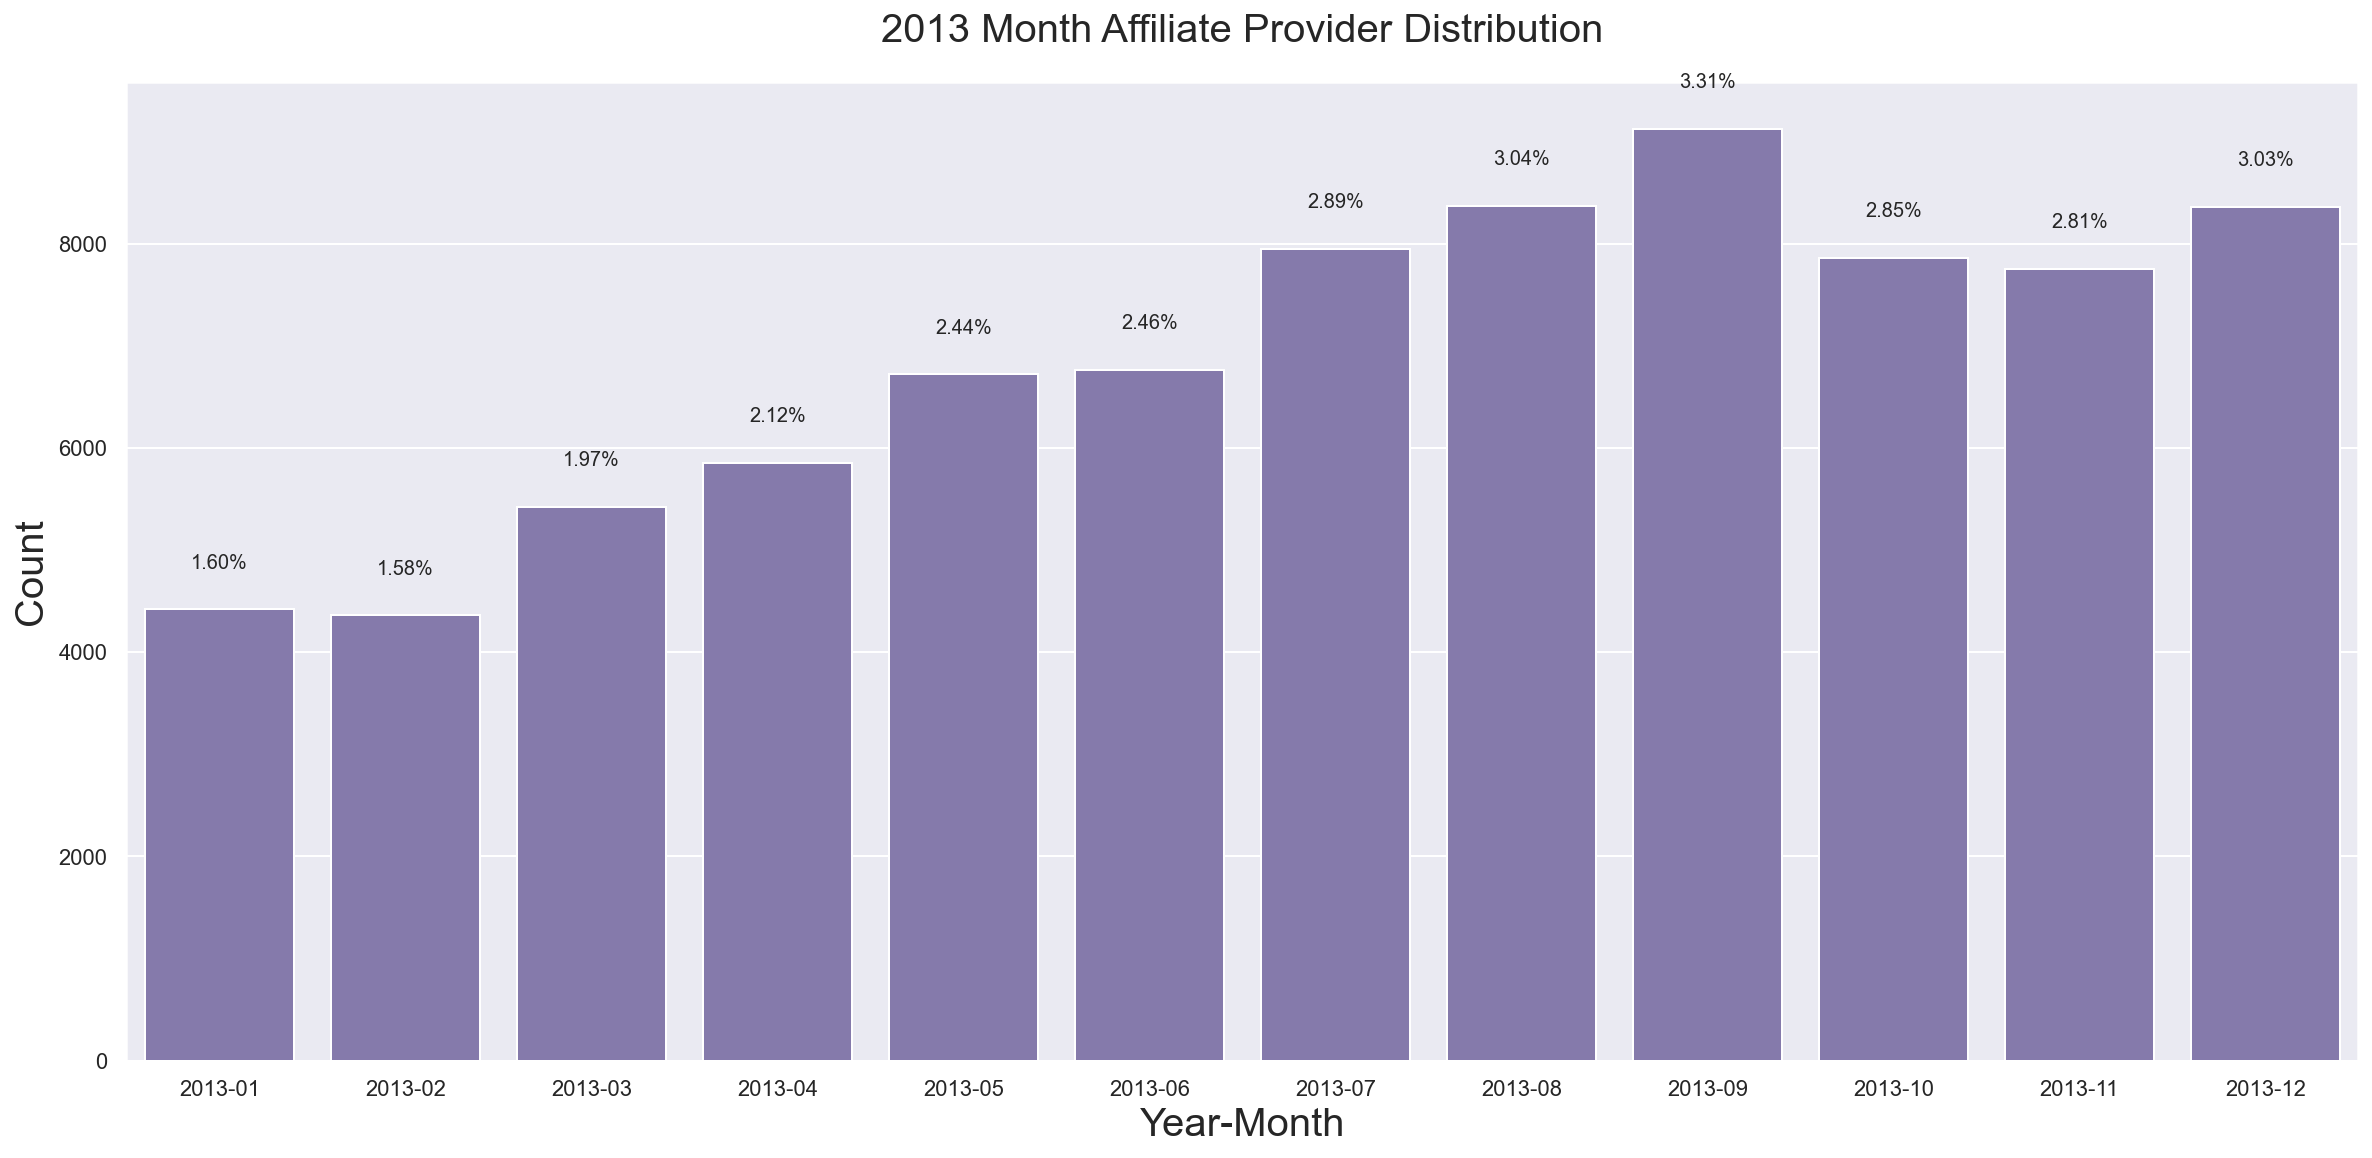

In [32]:
# 2013년 월별 제휴처 사용량을 기준 그래프
plt.figure(figsize=[20,9])
sns.barplot(data=df3, x=df3.index, y="affiliate_provider", color=sns.color_palette()[4])
plt.title("2013 Month Affiliate Provider Distribution", fontsize=20, pad=20);
plt.xlabel('Year-Month')
plt.ylabel('Count')

for i in range(df3.shape[0]):
    count = df3.iloc[i]["affiliate_provider"]
    strt = "{:0.2f}%".format(100*count / df_all.shape[0])
    plt.text(i, count+400, strt, ha = "center", fontsize=10)

- 2013년도도 2014년과 비슷한 추이를 보인다 대신 2013년도는 3월 9월까지 증가 기간이 길다는 것을 알 수 있다. 추가로 2013년도도 비성수기인 10월 즘 부터 이용량이 감소함을 알 수 있다. 아무래도 여행을 가는 성수기 비성수기 영향으 받지 않았나 조심스레 예측해본다.

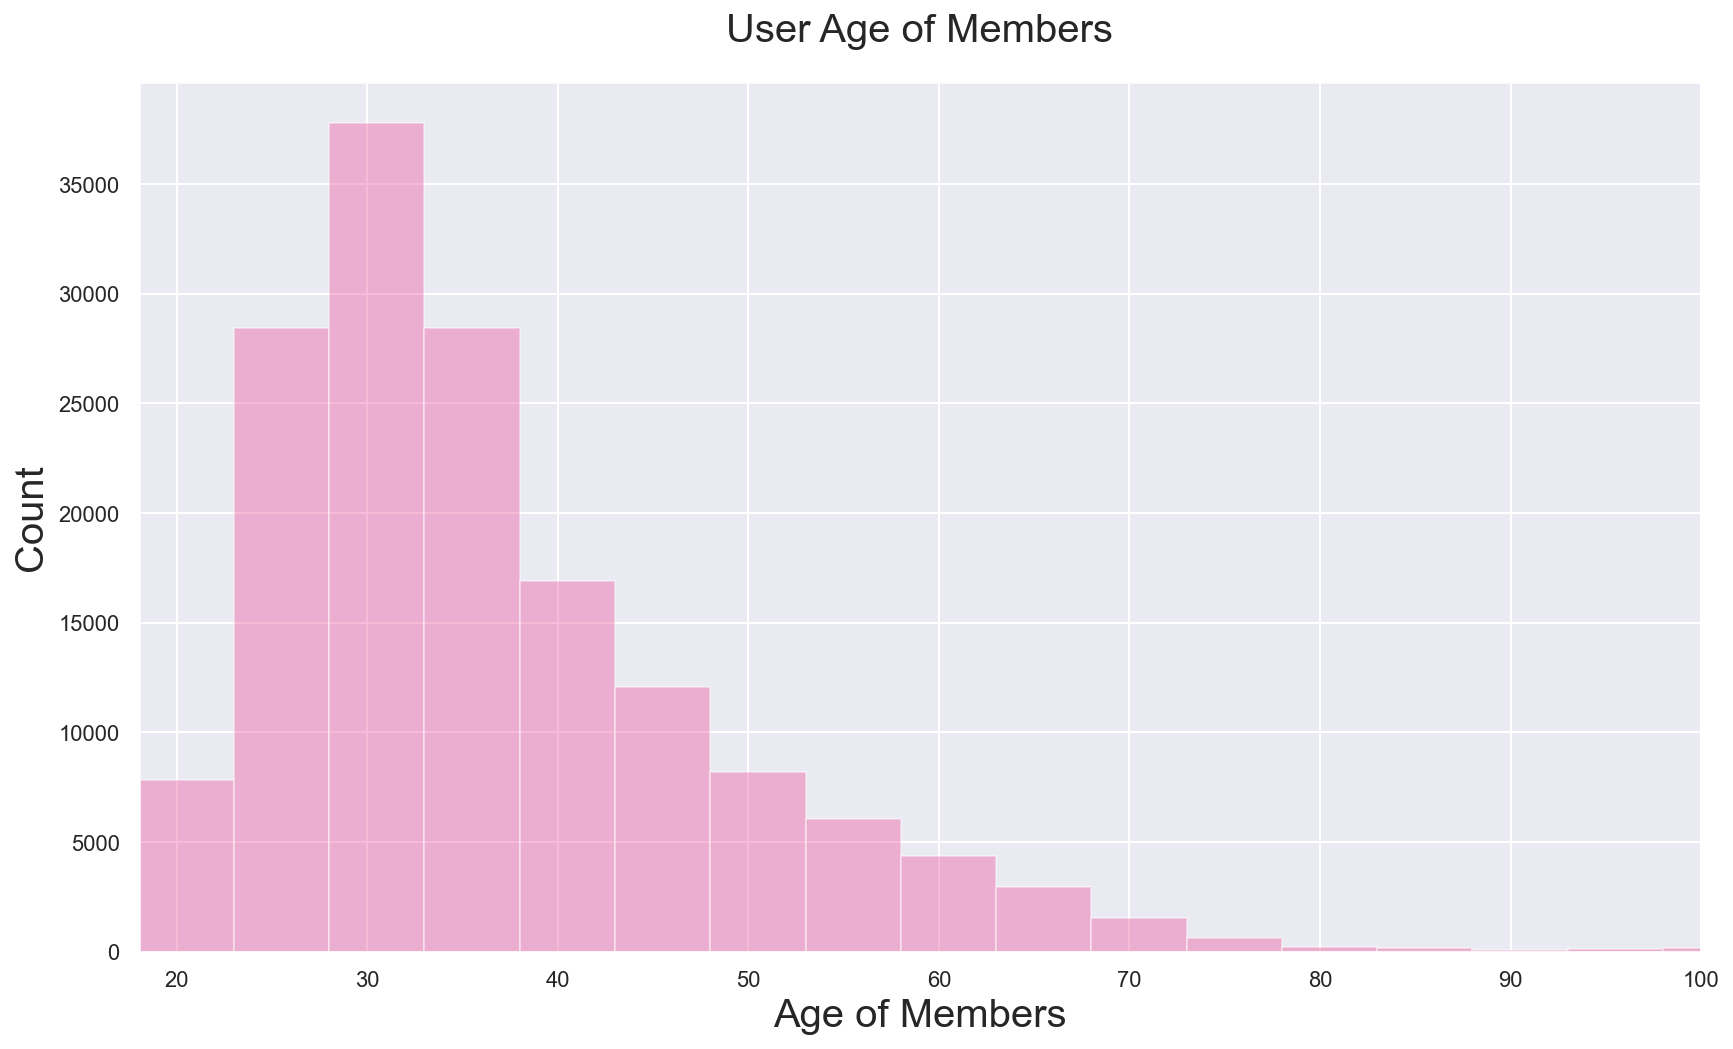

In [33]:
from matplotlib import font_manager, rc   
plt.rcParams['axes.unicode_minus'] = False   # 그래프 한글 설정을 위해 matplotlib에서 rc 불러오기 (한글 깨짐 현상을 막아줌)

# 구성원 연령별 분포도 
plt.figure(figsize=[14,8])
# sns.set(font_scale = 1.5)
sns.distplot(df_all.age.dropna(), bins=np.arange(18,100+5,5), color=sns.color_palette("RdPu", 10)[5], kde=False);
plt.xlabel('Age of Members')
plt.ylabel('Count')
plt.title("User Age of Members", fontsize=20, pad=20)
plt.xlim(18,100); # x축 최대값 지정

- 유저 구성원 연령의 분포도를 나타내본 결과 30대 비중이 가장 높음을 알 수 있다. 참고로 히스토그램에 line을 표현하려 하였으나, 결측치가 많아 그래프 line의 분포가 막대그래프를 따라가지 않아 line의 분포는 표현하지 않았다. 

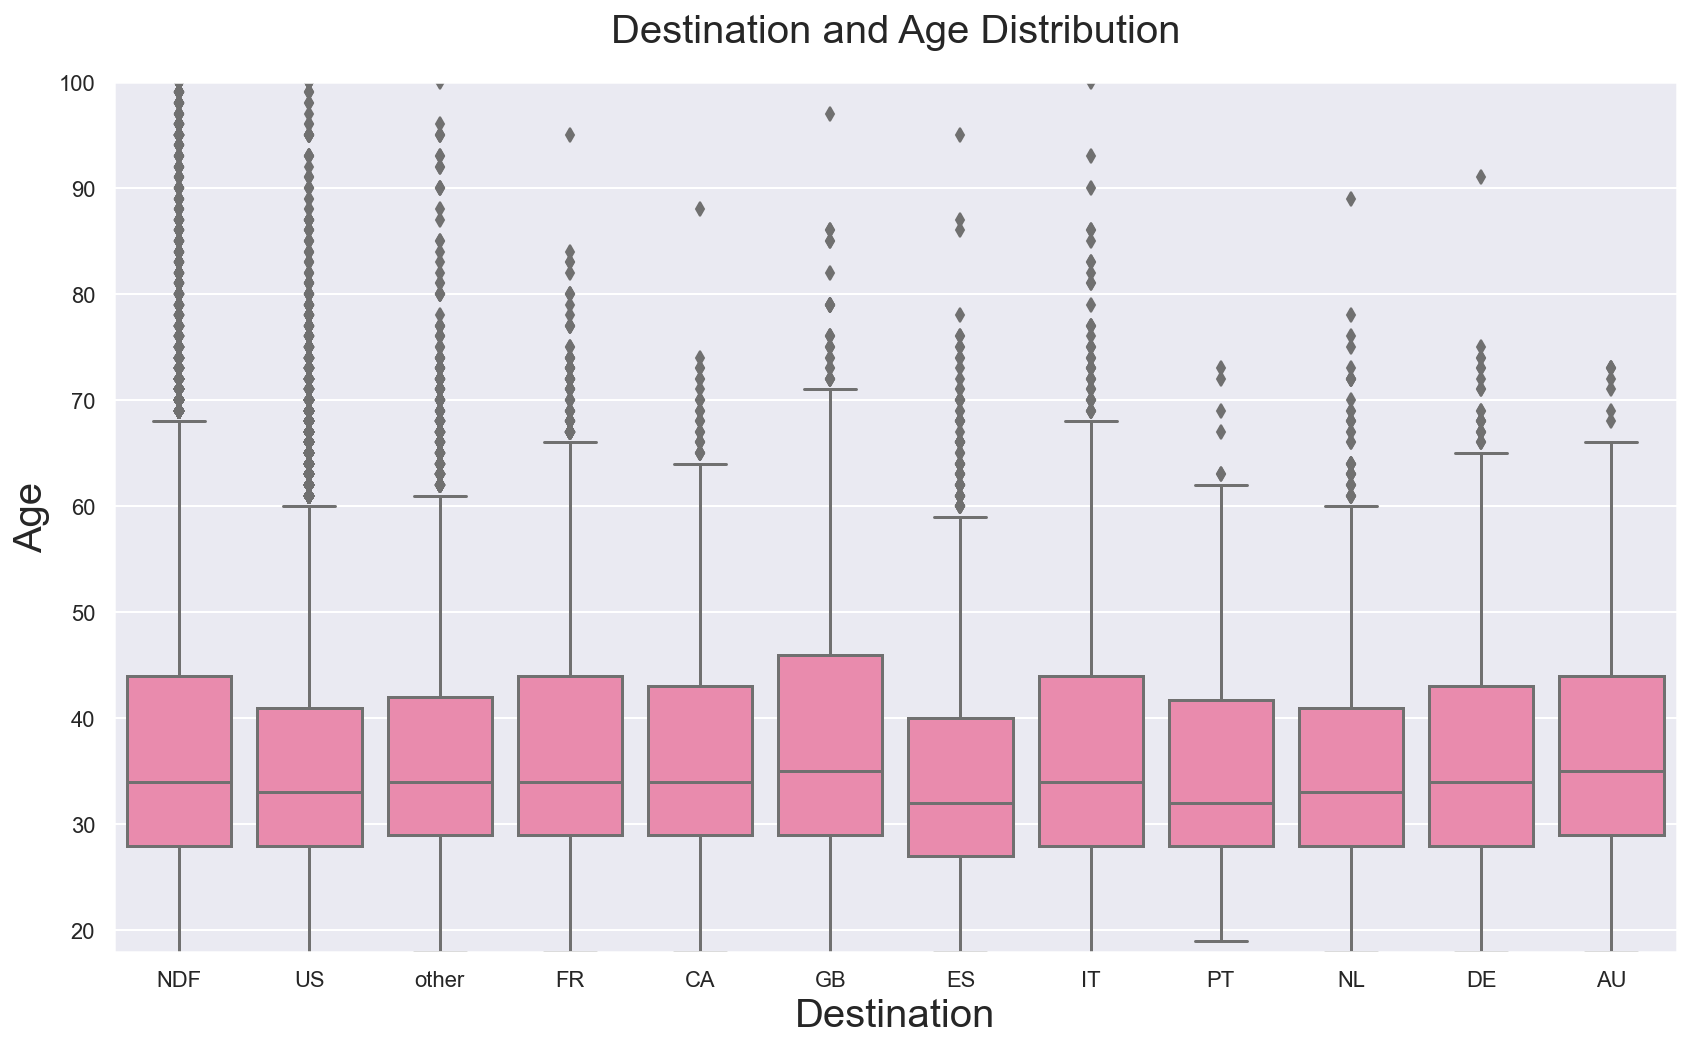

In [34]:
# 목적지와 구성원 연령 분포
plt.figure(figsize=[14,8])
sns.boxplot(data=df_all, y='age', x='country_destination', color=sns.color_palette("RdPu", 10)[4])
plt.ylim(18, 100) # y축 최대값 지정 (시작, 끝)
plt.xlabel('Destination');
plt.ylabel('Age');
plt.title("Destination and Age Distribution", fontsize=20, pad=20);

- 목적지 국가와 연령대의 분포를 살펴본 결과 모두 20~40대 사이의 분포가 가장 높으며, 모든 목적지 boxplot의 중앙값이 30대임을 알 수 있다. 추가적으로 각각 outlier의 분포가 너무 많아 해당 outlier를 어떻게 처리 할 것인지 고민이 필요하다.

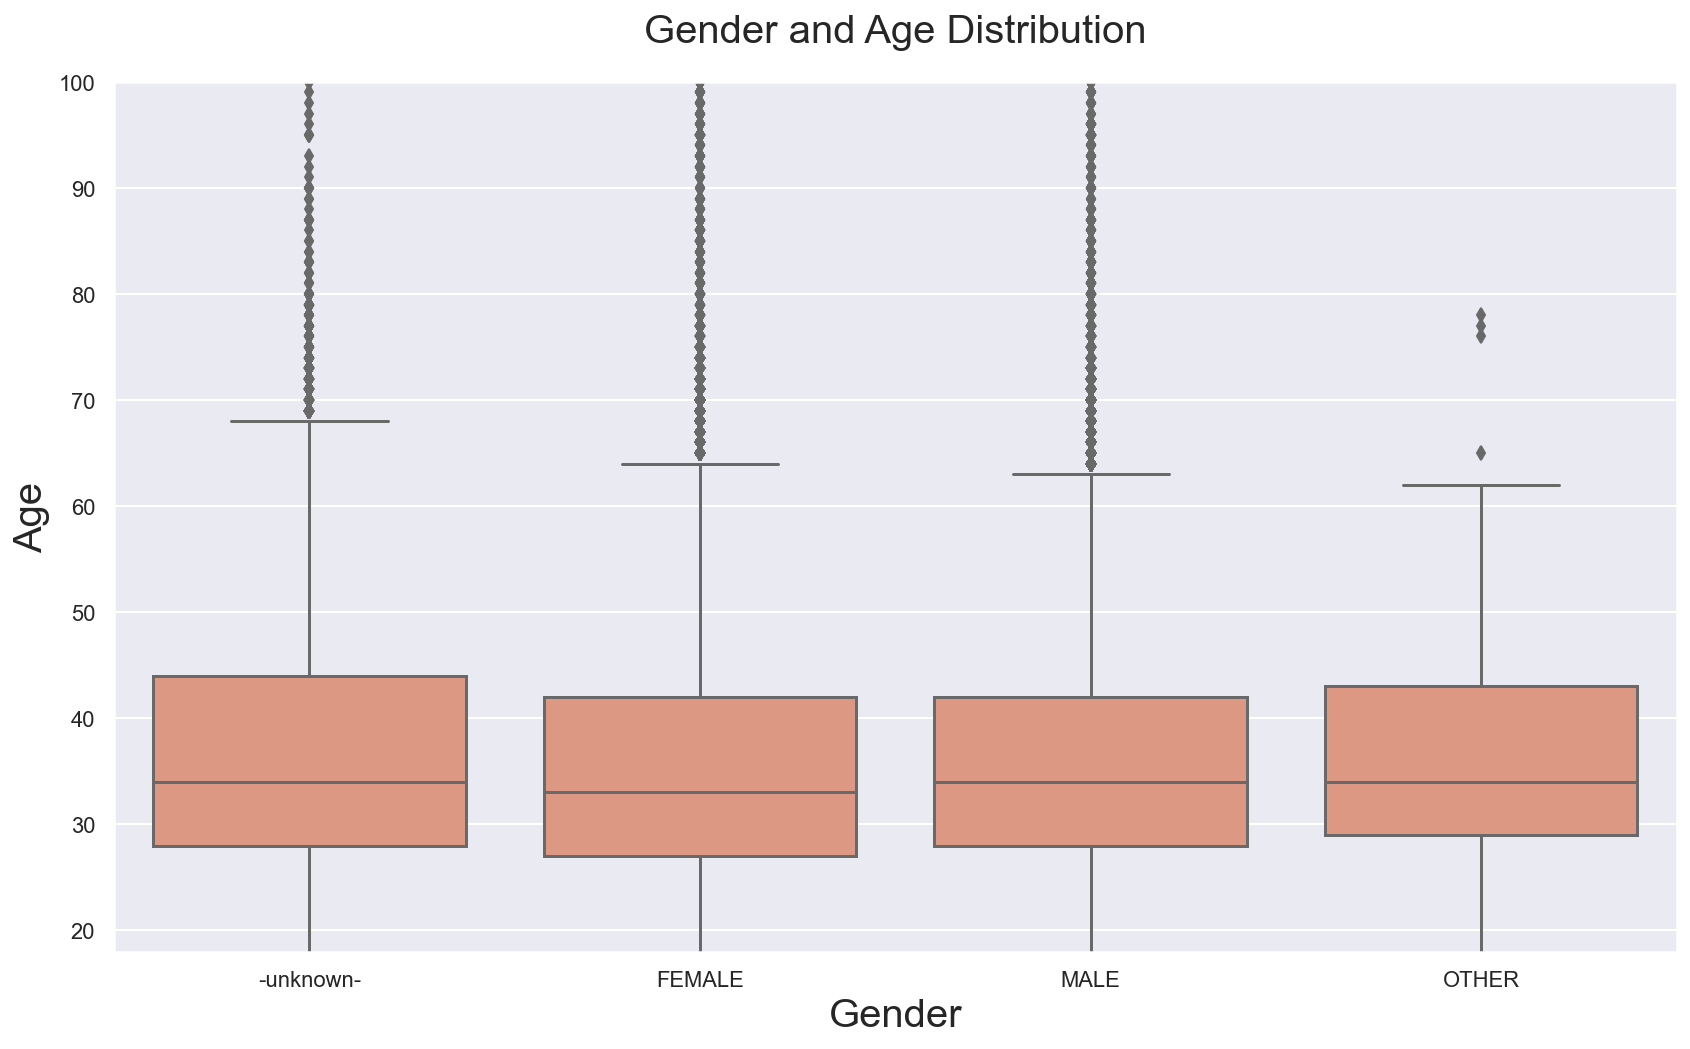

In [35]:
# 성별과 유저 연령 분포 
plt.figure(figsize=[14,8])
sns.boxplot(data=df_all, y='age', x='gender', color=sns.color_palette("RdBu", 10)[2]);
plt.ylim(18, 100) # y축 최대값 지정 (시작, 끝)
plt.xlabel('Gender');
plt.ylabel('Age');
plt.title("Gender and Age Distribution", fontsize=20, pad=20);

- 성별 대비 연령대를 살펴본 결과 모든 성별의 분포가 20대~40대 사이이며, 중앙값은 30대로 이용이 가장 활발한 연령대임을 알 수 있다. 추가로 unknown의 수가 높음을 알 수있다.

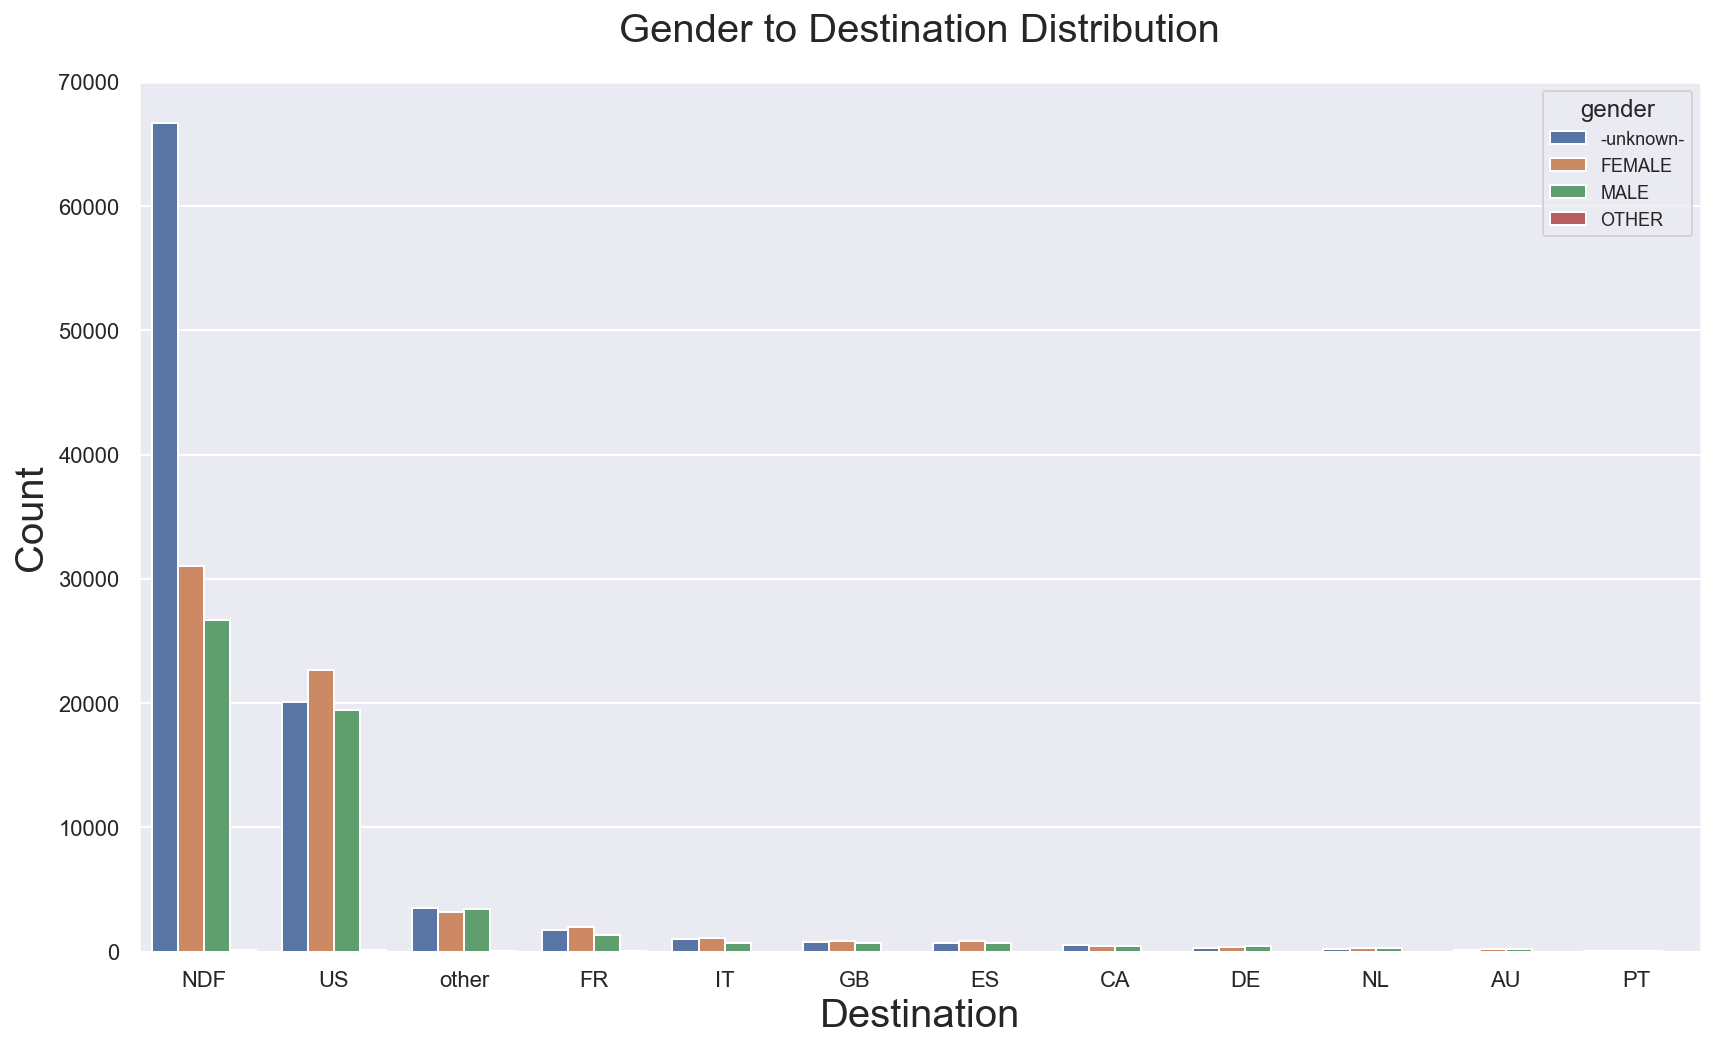

In [36]:
# 목적지 국가별 유저 성별 분포 
plt.figure(figsize=(14,8))
order1 = df_all['country_destination'].value_counts().index
sns.countplot(data = df_all, x = 'country_destination', order = order1, hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title("Gender to Destination Distribution", fontsize=20, pad=20)
order2 = df_all['country_destination'].value_counts()

- 목적지대비 성별 분포를 확인해본 결과 NDF(예약한적 없음)는 알수없는 성별 -> 여성 -> 남성 순으로 높았다.

In [37]:
df_all["first_device_type"].value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

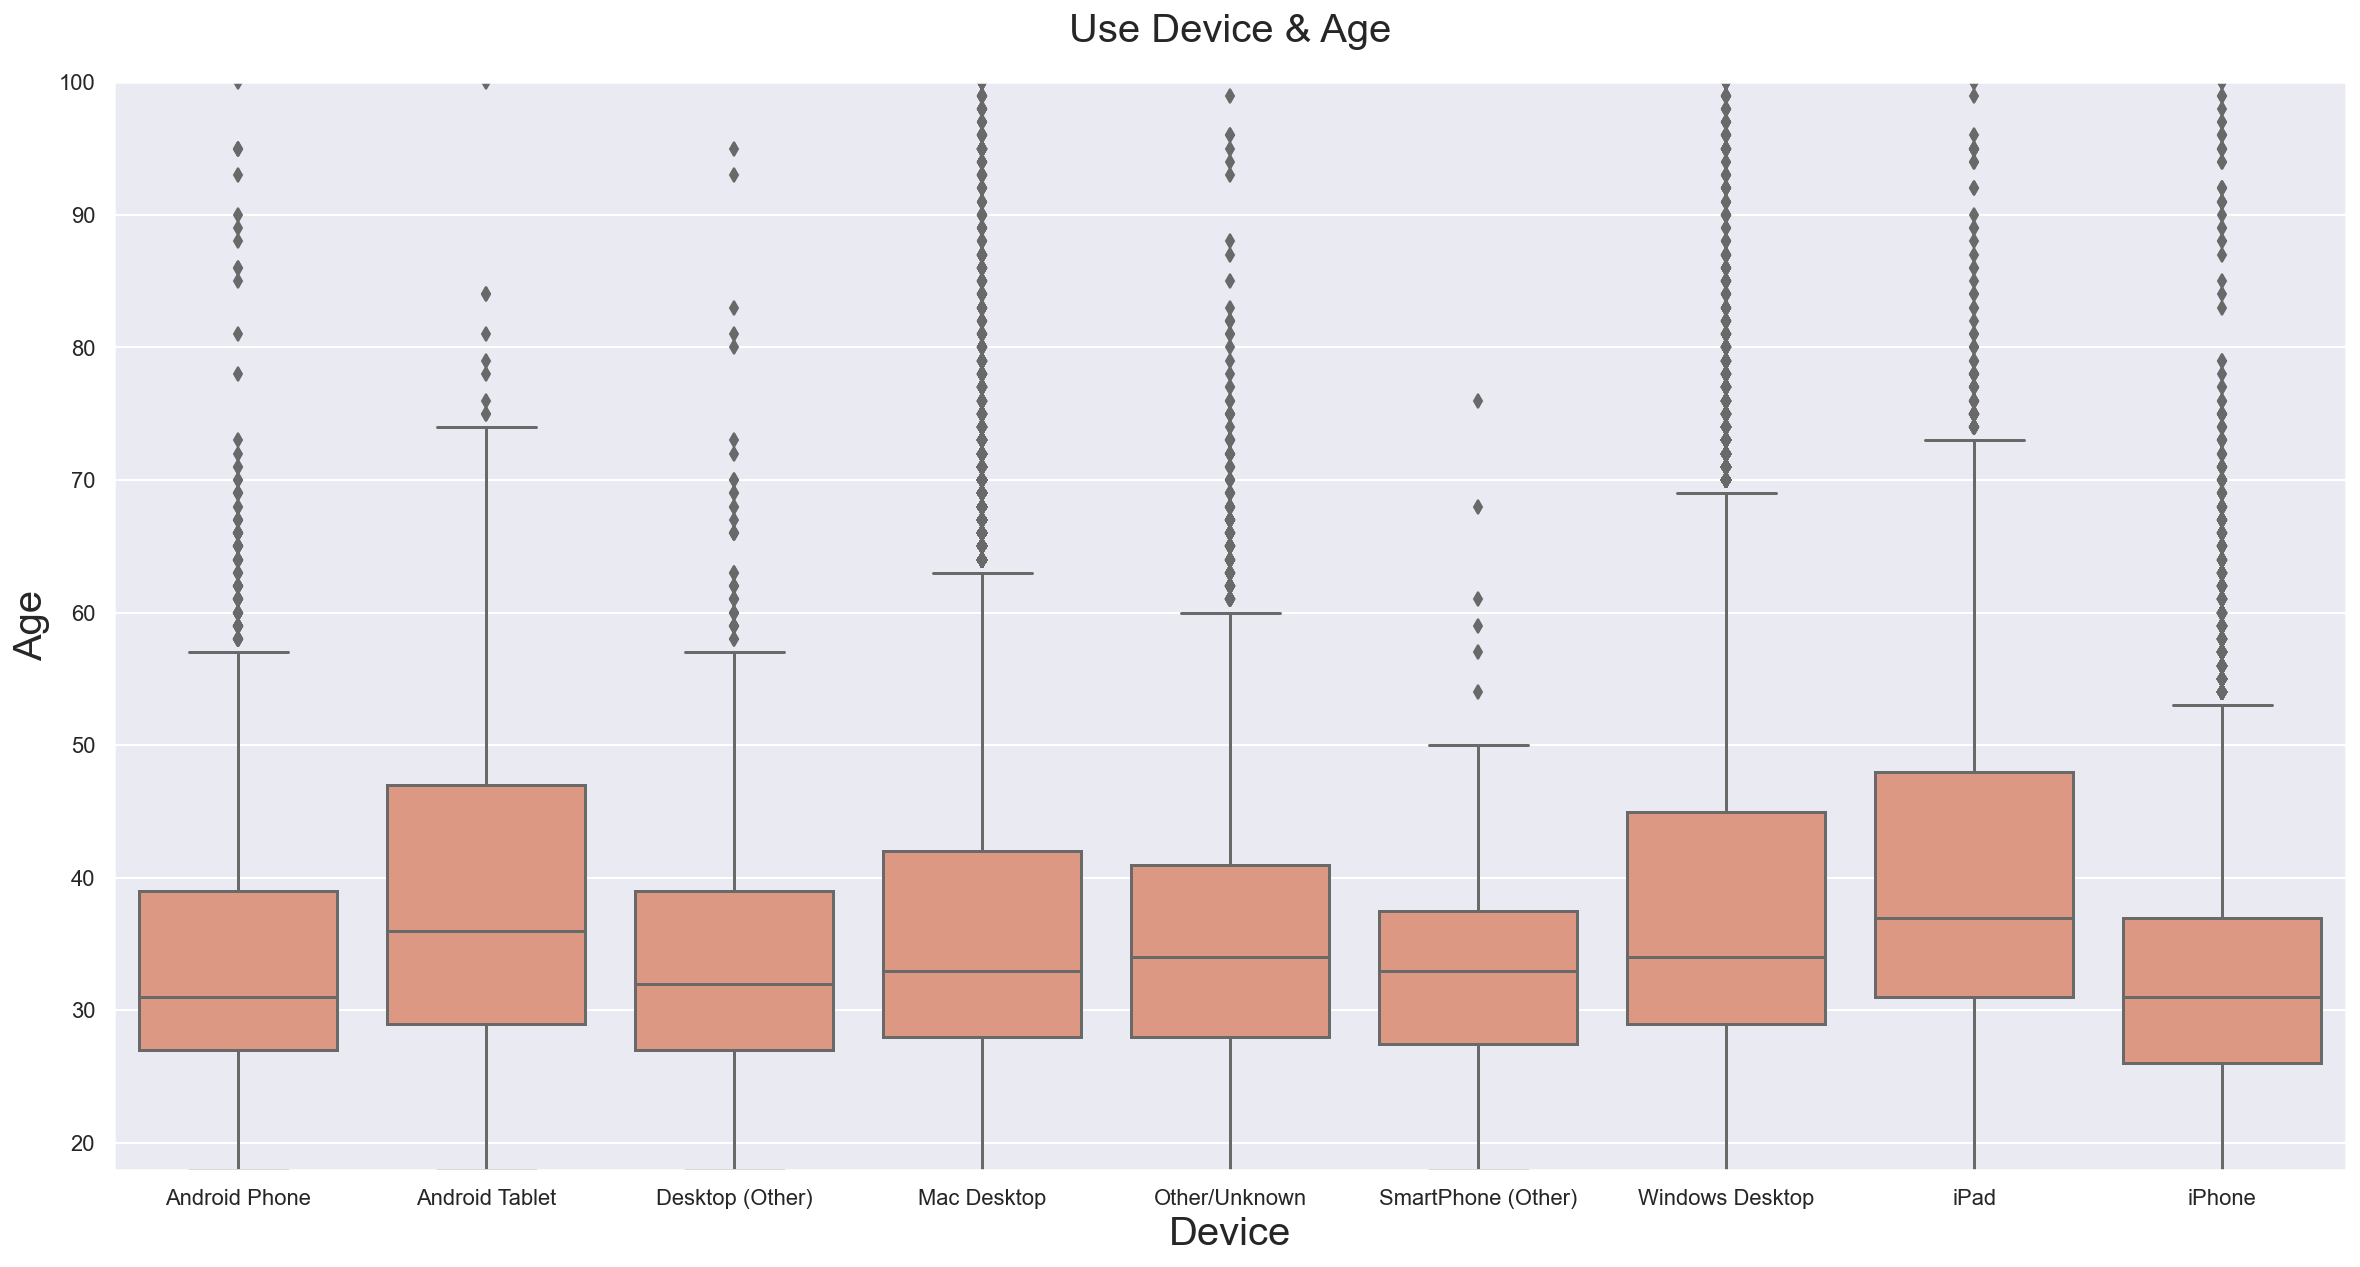

In [38]:
# 성별과 유저 연령 분포 
plt.figure(figsize=[20,10])
sns.boxplot(data=df_all, y='age', x='first_device_type', color=sns.color_palette("RdBu", 10)[2]);
plt.ylim(18, 100) # y축 최대값 지정 (시작, 끝)
plt.xlabel('Device');
plt.ylabel('Age');
plt.title("Use Device & Age", fontsize=20, pad=20);

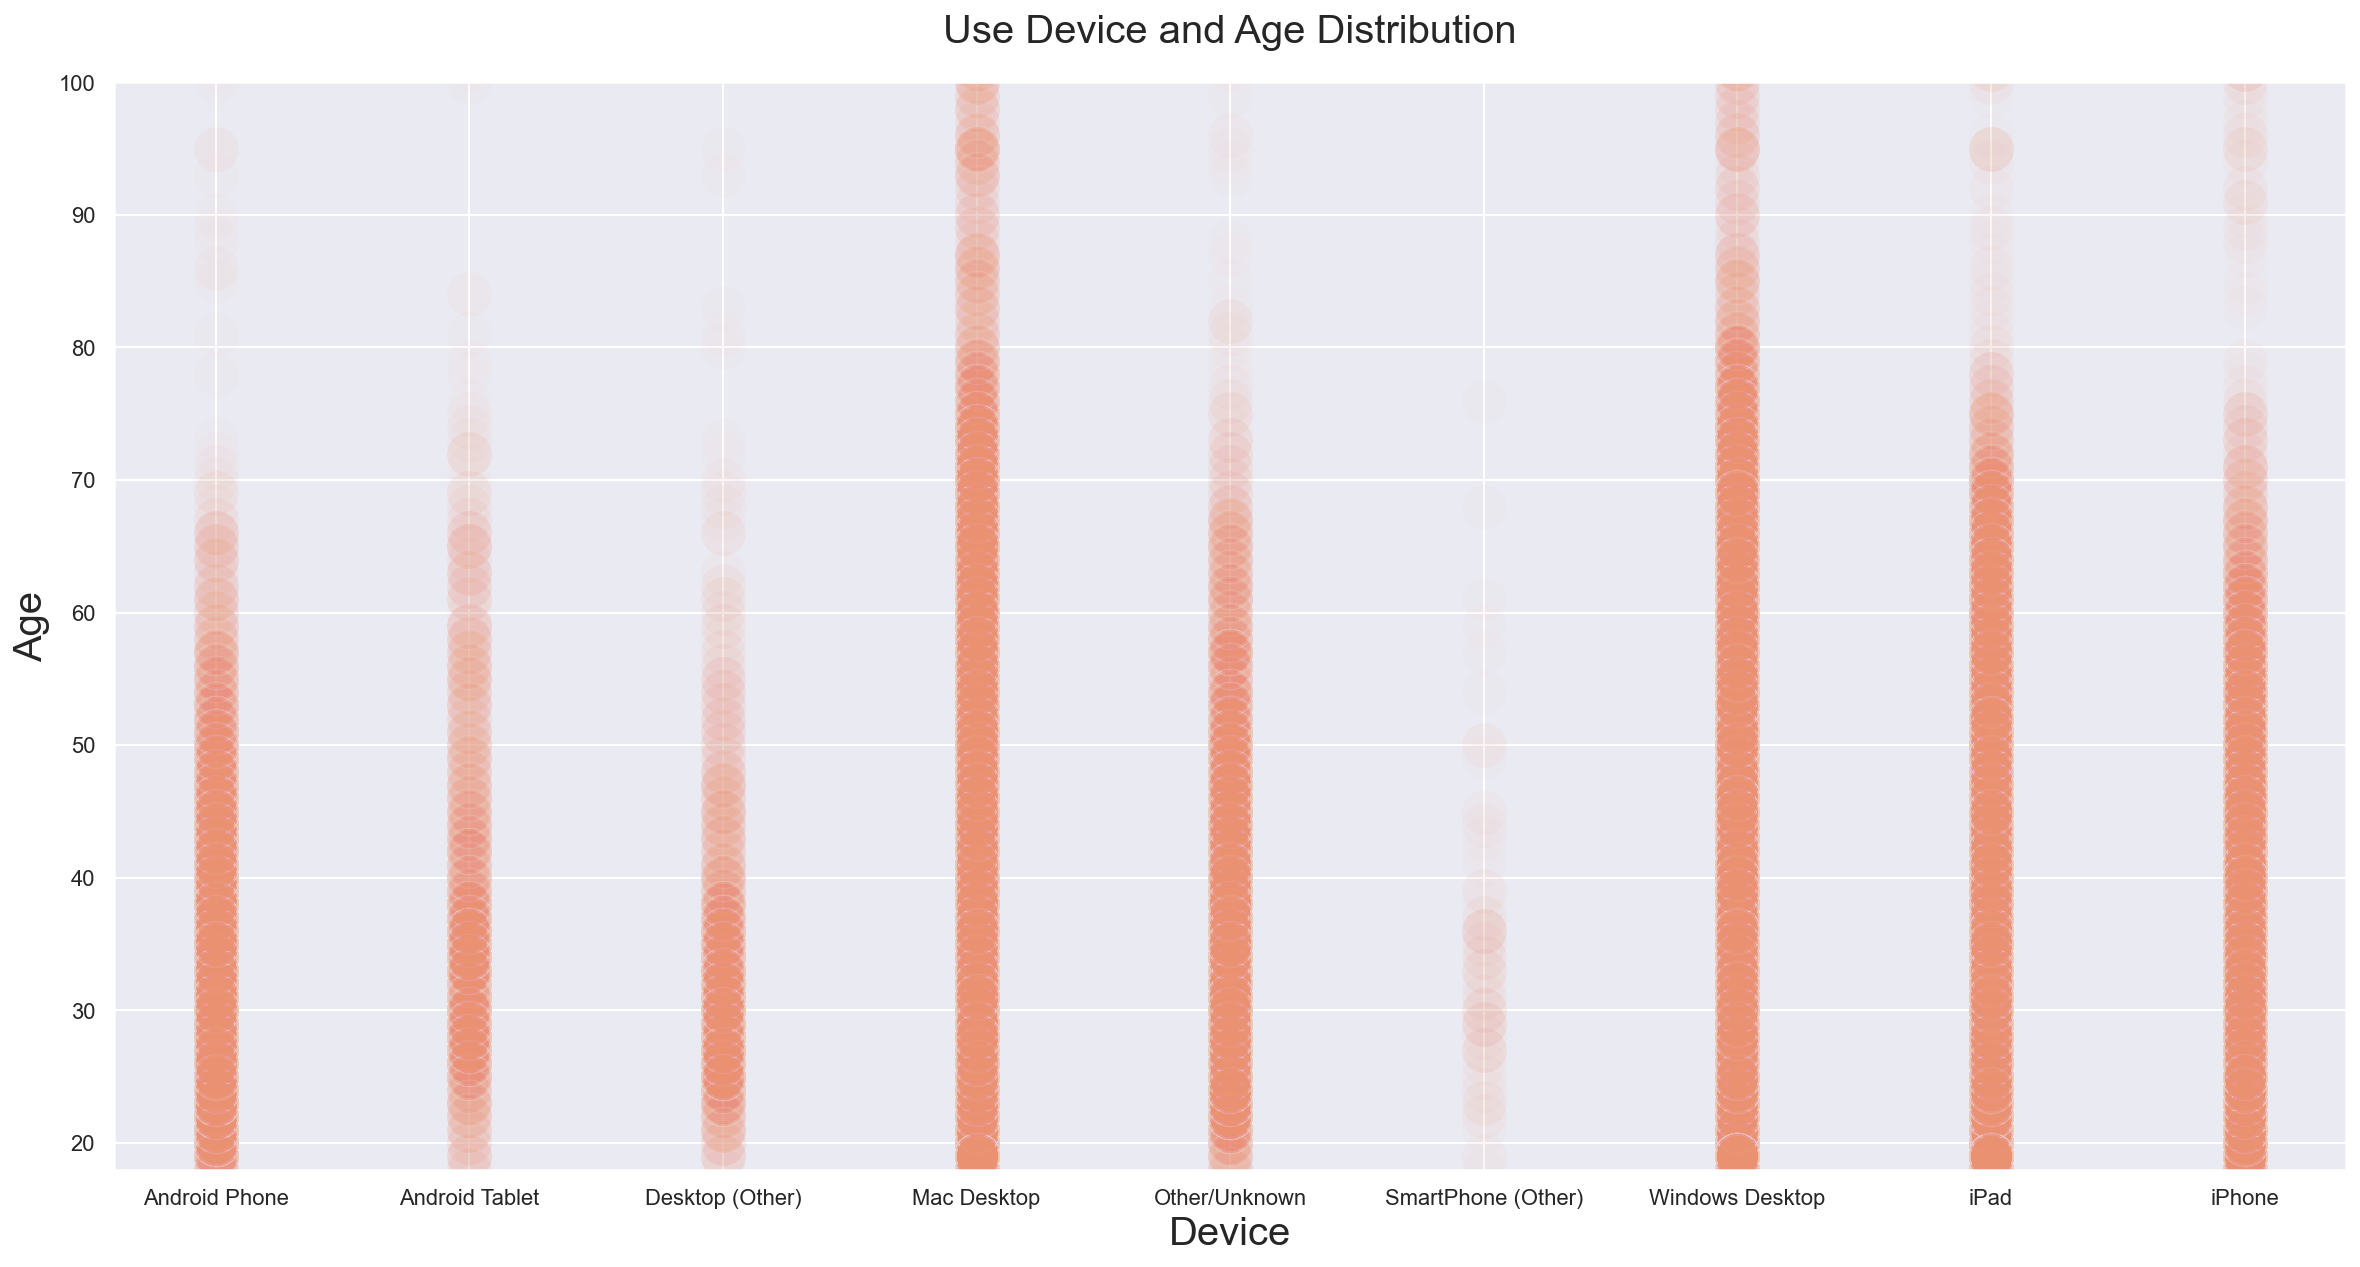

In [39]:
plt.figure(figsize=[20,10])
sns.scatterplot(data=df_all, y='age', x='first_device_type', 
                color=sns.color_palette("RdBu", 10)[2], alpha=0.02, s=500);
plt.ylim(18, 100) # y축 최대값 지정 (시작, 끝)
plt.xlabel('Device');
plt.ylabel('Age');
plt.title("Use Device and Age Distribution", fontsize=20, pad=20);

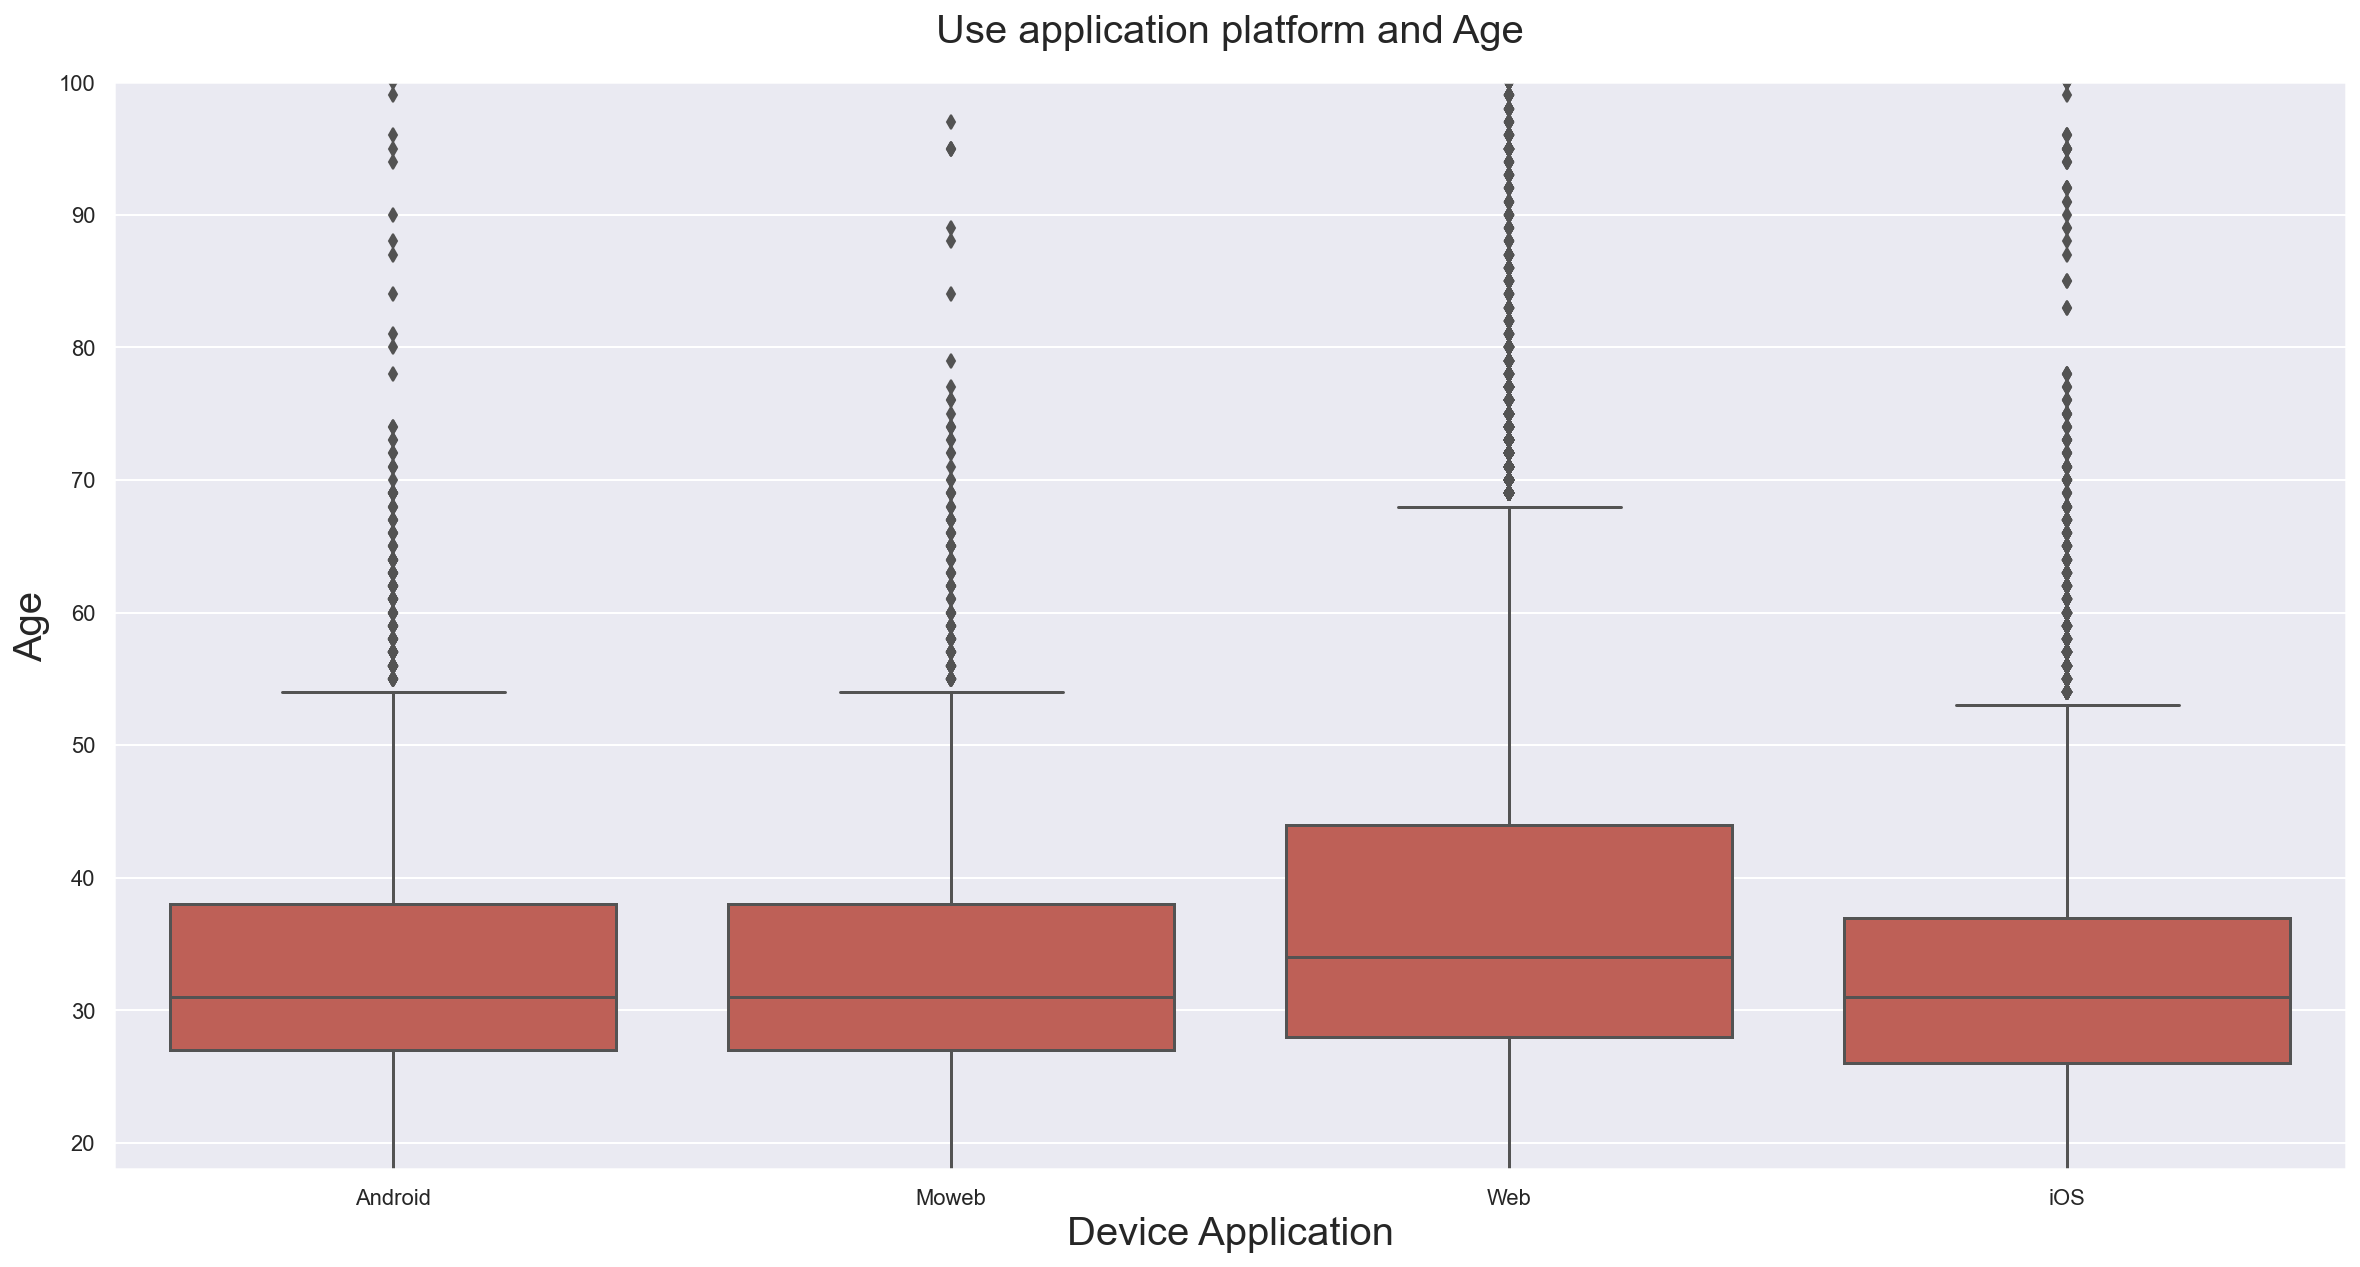

In [40]:
plt.figure(figsize=[20,10])
plt.rc('font', size=0.0005)
sns.boxplot(data=df_all, y='age', x='signup_app', color=sns.color_palette("RdBu", 10)[1]);
plt.ylim(18, 100) # y축 최대값 지정 (시작, 끝)
plt.xlabel('Device Application');
plt.ylabel('Age');
plt.title("Use application platform and Age", fontsize=20, pad=20);

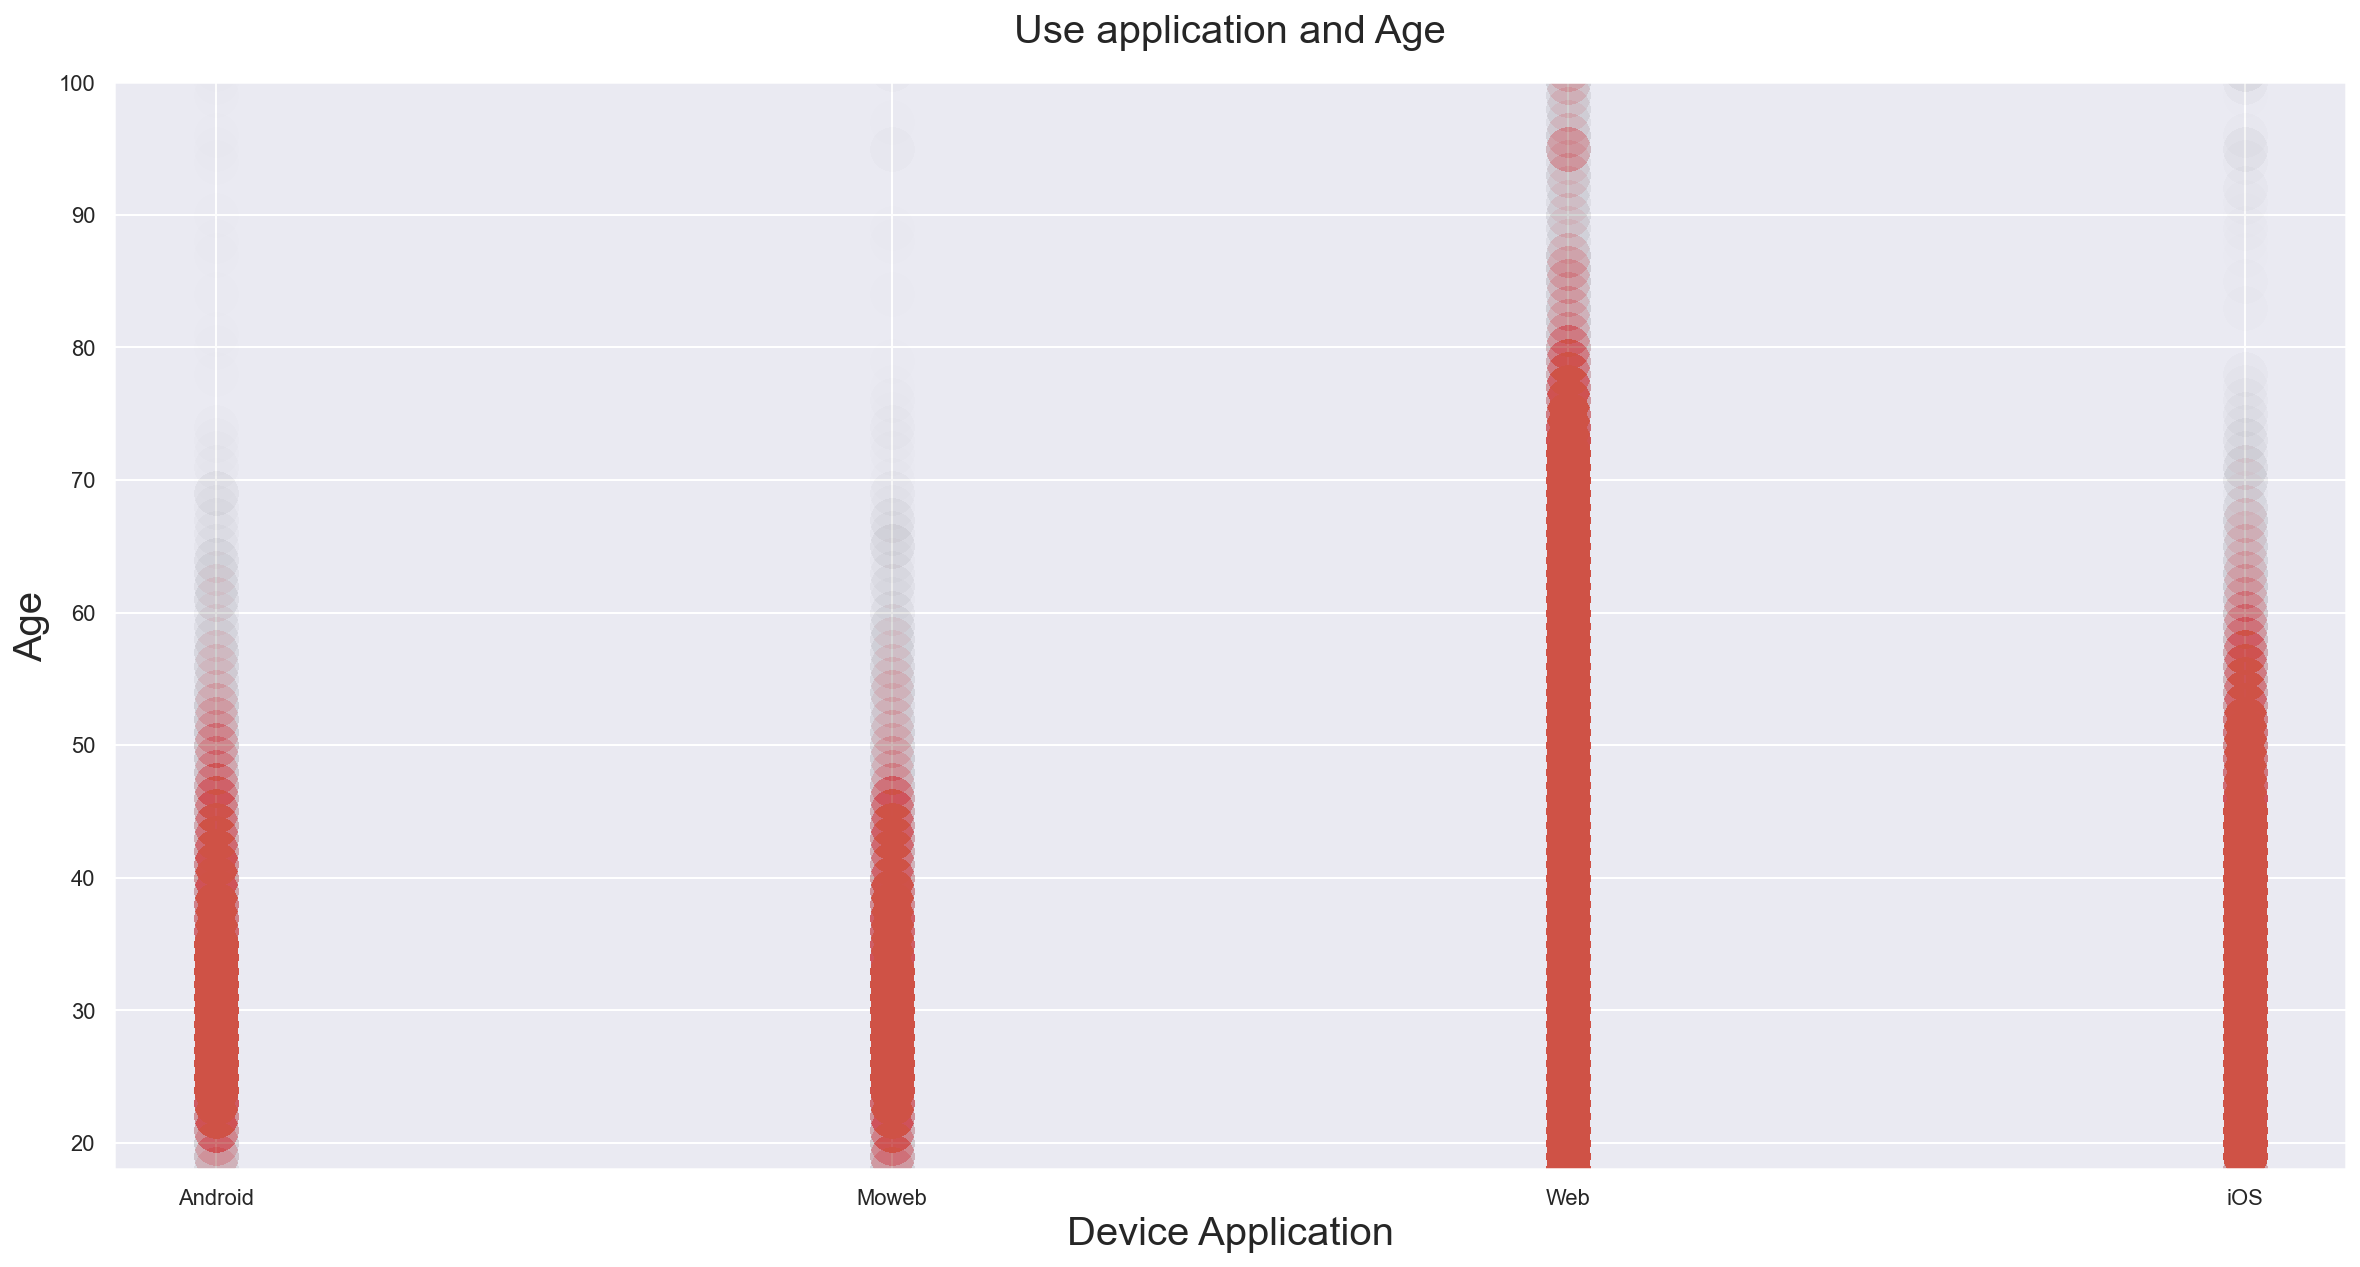

In [41]:
plt.figure(figsize=[20,10])
sns.scatterplot(data=df_all, y='age', x='signup_app', 
                color=sns.color_palette("RdBu", 10)[1], alpha=0.005, s=500);

plt.ylim(18, 100) # y축 최대값 지정 (시작, 끝)
plt.xlabel('Device Application');
plt.ylabel('Age');
plt.title("Use application and Age", fontsize=20, pad=20);

- 연령대 대비 디바이스 이용 분포를 살펴본 결과 Mac Desktop -> Window Desktop -> ipad -> iPhone 순으로 이용 하였다. 여기서 추가로 알 수 있는 점은, 위 4개의 디바이스의 이용 연령대가 고르게 분포되었지만 Android Phone의 이용 연령대는 그렇게 높지 않았던 점이다. (데이터의 기준이 미국인들을 생각하면 어떻게 보면 당연한 결과지 않을까 생각이 듬)
- 디바이스 이용 분포를 바탕으로 연령대 대비 디바이스 어플리케이션 이용 분포를 살펴 본 결과 WEB 사용량이 압도적으로 많았다.

In [42]:
from pyecharts import Line

create = pd.DataFrame(df_all["date_account_created"].value_counts().sort_index())

keys = list(create["date_account_created"].keys())
values = list(create["date_account_created"].values)

line = Line("Date ccount created")
line.add("", keys, values, label_color=['#FF9999'], mark_point=["min", "max"])

line.height = 500
line.width = 1100

line

- 계정 시작일수의 추이를 보면 계속해서 증가하고 있다.

In [43]:
df3_1 = df_all[df_all["date_account_created"].dt.year == 2013]
df3_1['monthyear13'] = df3_1["date_account_created"].map(lambda x: x.strftime("%Y-%m"))
df3_1 = df3_1.groupby(['monthyear13', 'member_age_bins']).count()
df3_1.reset_index(inplace=True)

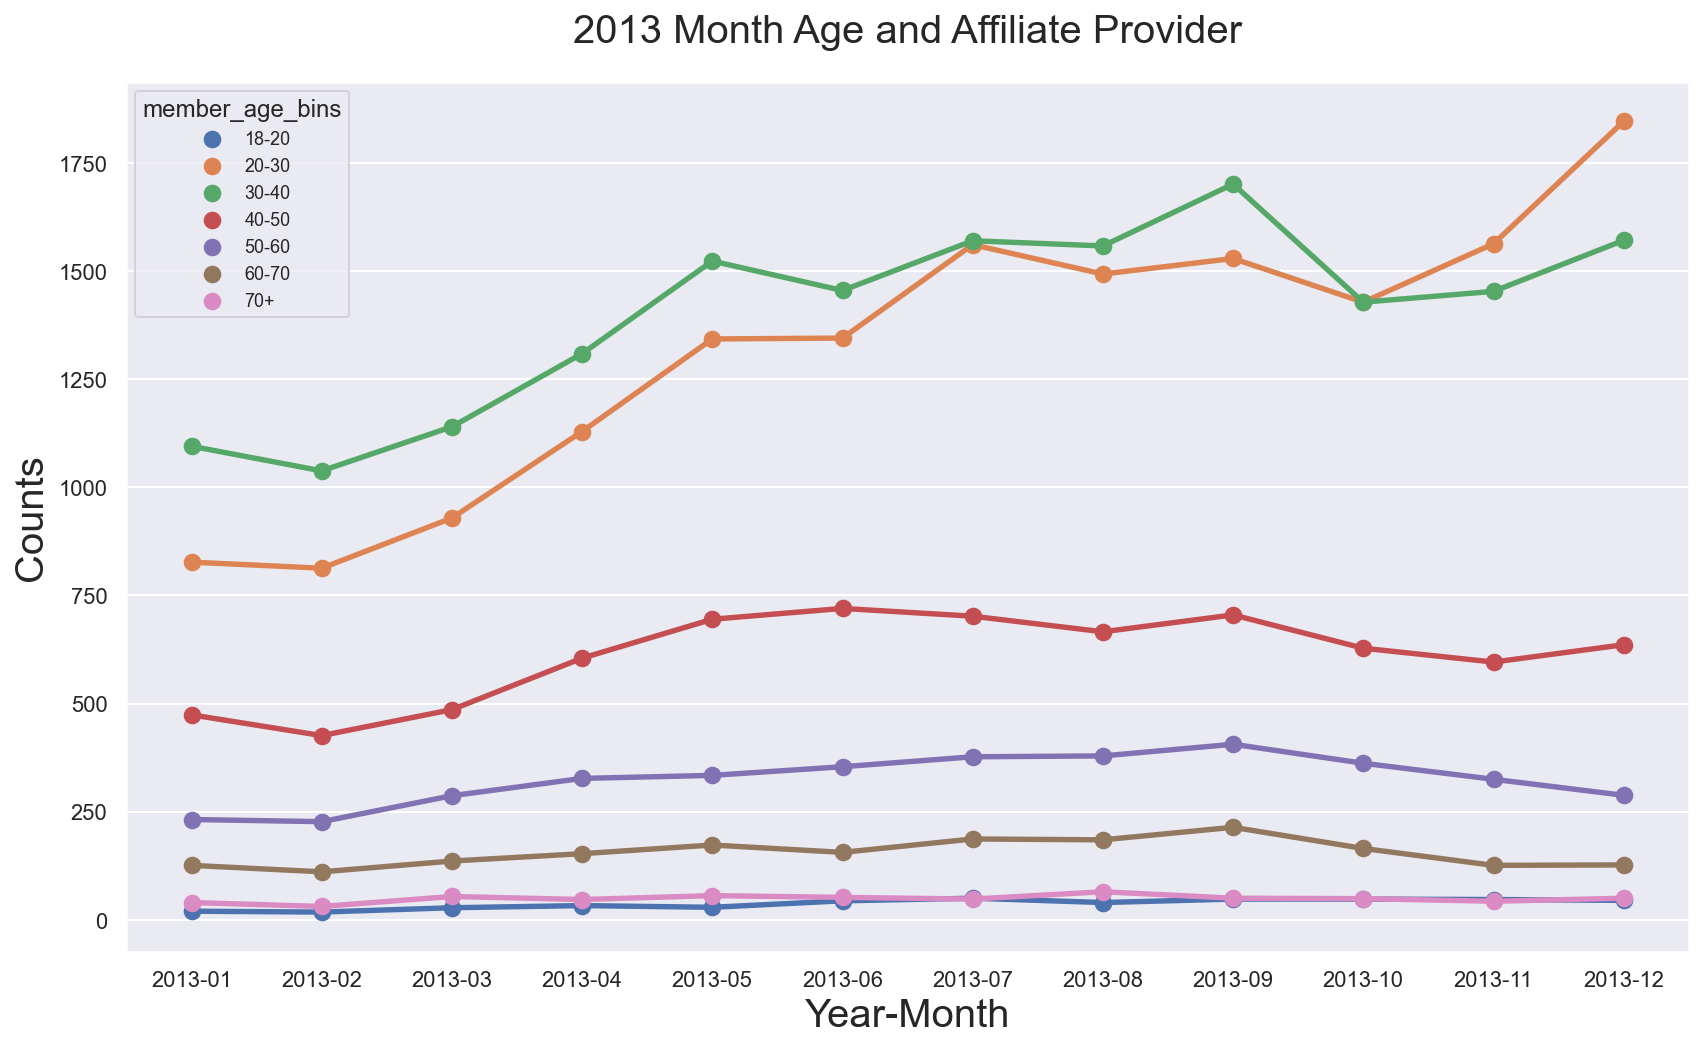

In [44]:
# 2013년 월별 연령대 대비 제휴 제공자 이용 분포 
plt.figure(figsize=[14,8])
sns.pointplot(data=df3_1, x="monthyear13", y="affiliate_provider", hue="member_age_bins");
plt.title("2013 Month Age and Affiliate Provider", fontsize=20, pad=20);
plt.xlabel("Year-Month");
plt.ylabel('Counts');

In [45]:
df3_2 = df_all[df_all["date_account_created"].dt.year == 2013]
df3_2['monthyear13'] = df3_2["date_account_created"].map(lambda x: x.strftime("%Y-%m"))
df3_2 = df3_2.groupby(['monthyear13', 'gender']).count()
df3_2.reset_index(inplace=True)

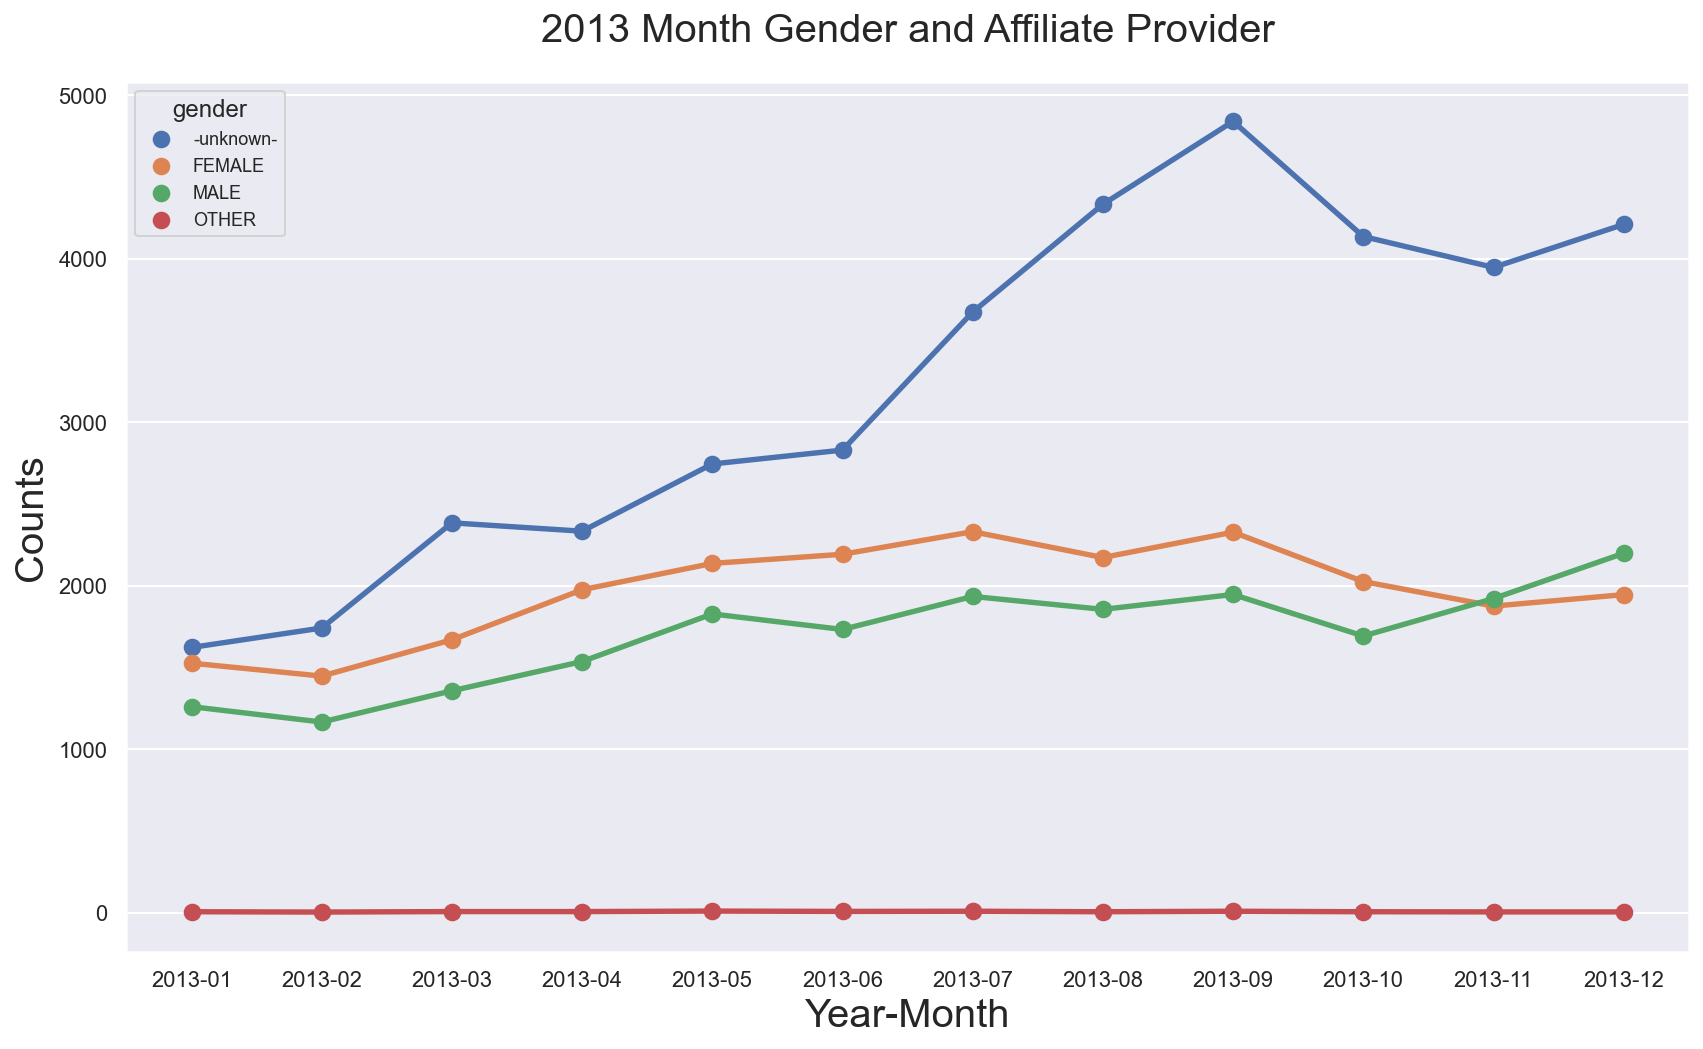

In [46]:
# 2013년 월별 성별 대비 제휴 제공자 이용 분포 
plt.figure(figsize=[14,8])
sns.pointplot(data=df3_2, x="monthyear13", y="affiliate_provider", hue="gender");
plt.title("2013 Month Gender and Affiliate Provider", fontsize=20, pad=20);
plt.xlabel("Year-Month");
plt.ylabel('Counts');

In [47]:
df4_1 = df_all[df_all["date_account_created"].dt.year == 2014]
df4_1['monthyear13'] = df4_1["date_account_created"].map(lambda x: x.strftime("%Y-%m"))
df4_1 = df4_1.groupby(['monthyear13', 'member_age_bins']).count()
df4_1.reset_index(inplace=True)

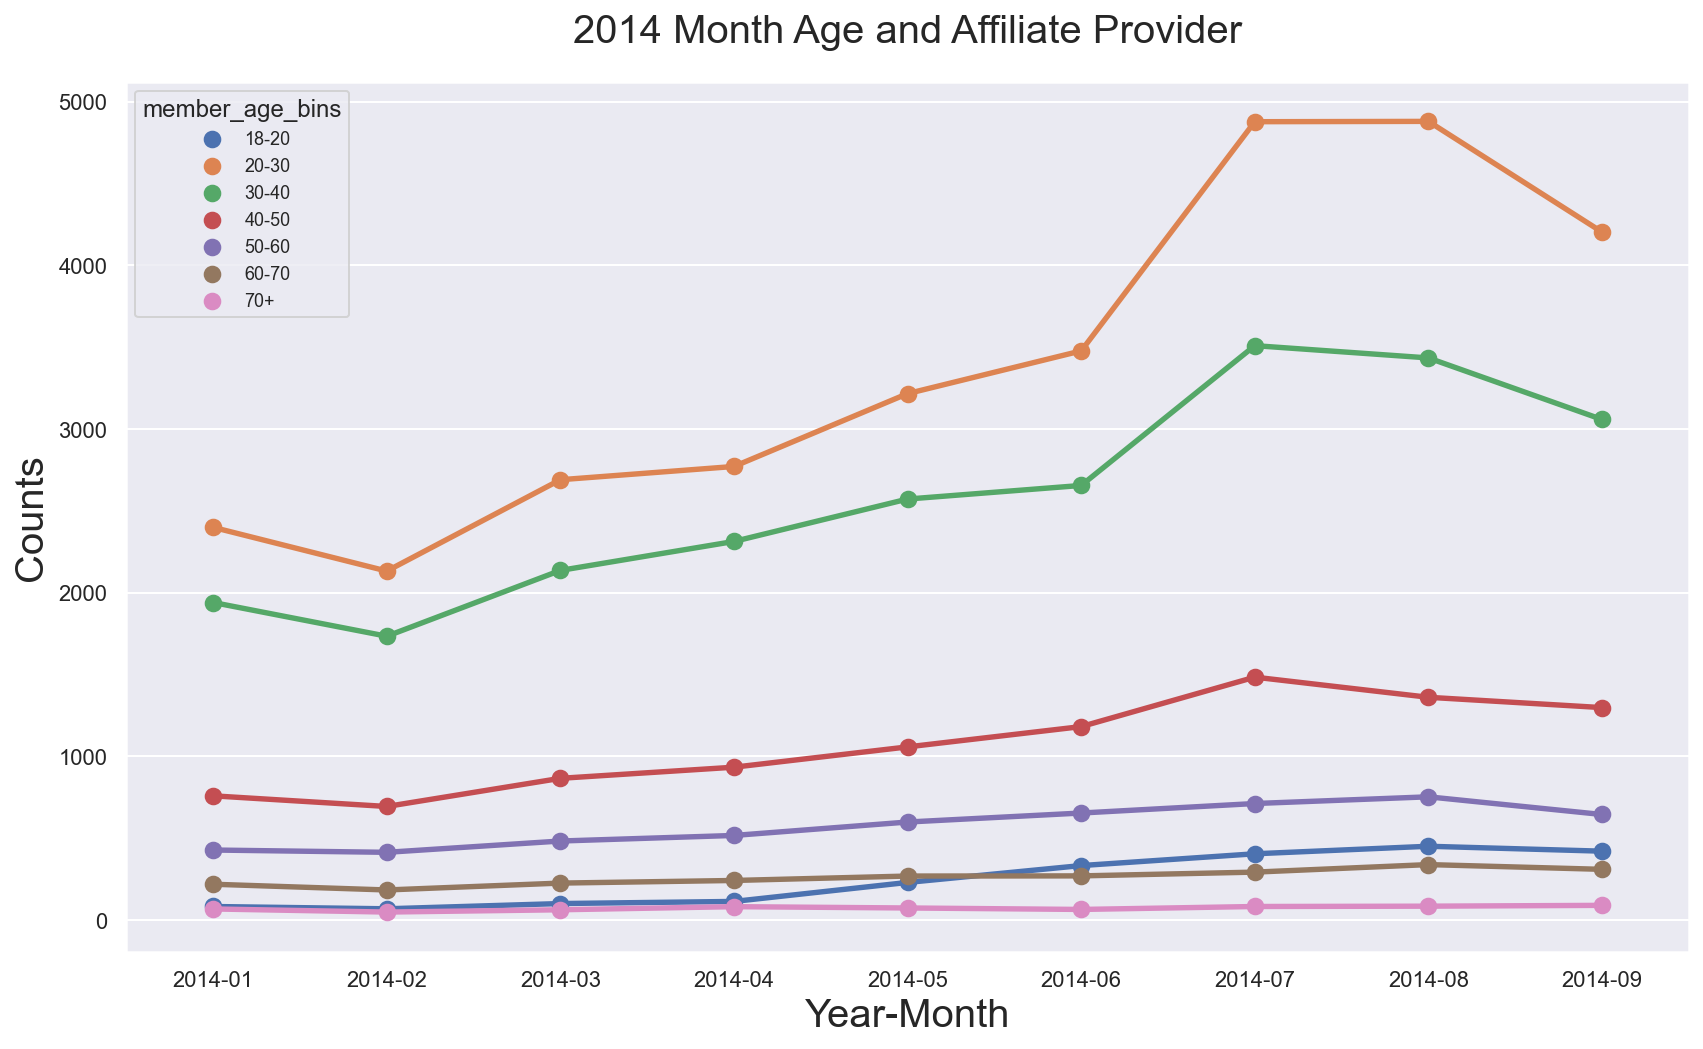

In [48]:
# 2014년 월별 연령대 대비 제휴 제공자 이용 분포 
plt.figure(figsize=[14,8])
sns.pointplot(data=df4_1, x="monthyear13", y="affiliate_provider", hue="member_age_bins");
plt.title("2014 Month Age and Affiliate Provider", fontsize=20, pad=20);
plt.xlabel("Year-Month");
plt.ylabel('Counts');

In [49]:
df4_2 = df_all[df_all["date_account_created"].dt.year == 2014]
df4_2['monthyear13'] = df4_2["date_account_created"].map(lambda x: x.strftime("%Y-%m"))
df4_2 = df4_2.groupby(['monthyear13', 'gender']).count()
df4_2.reset_index(inplace=True)

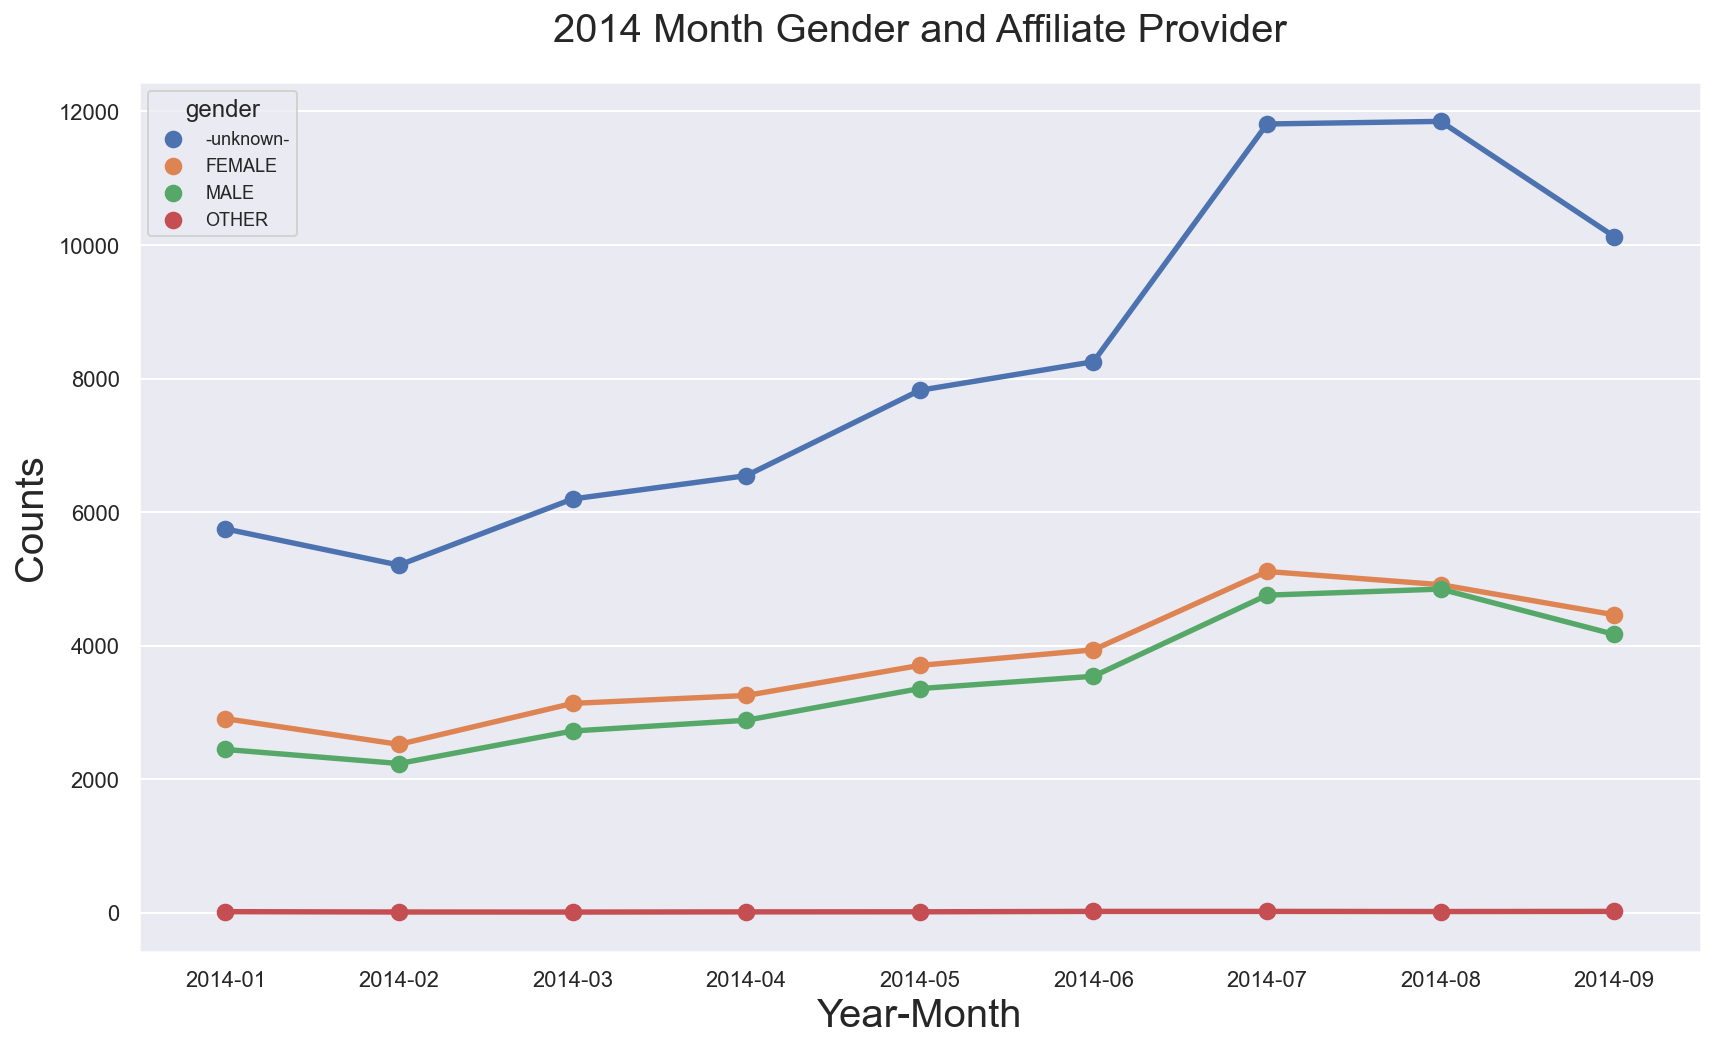

In [50]:
# 2014년 월별 성별 대비 제휴 제공자 이용 분포 
plt.figure(figsize=[14,8])
sns.pointplot(data=df4_2, x="monthyear13", y="affiliate_provider", hue="gender");
plt.title("2014 Month Gender and Affiliate Provider", fontsize=20, pad=20);
plt.xlabel("Year-Month");
plt.ylabel('Counts');

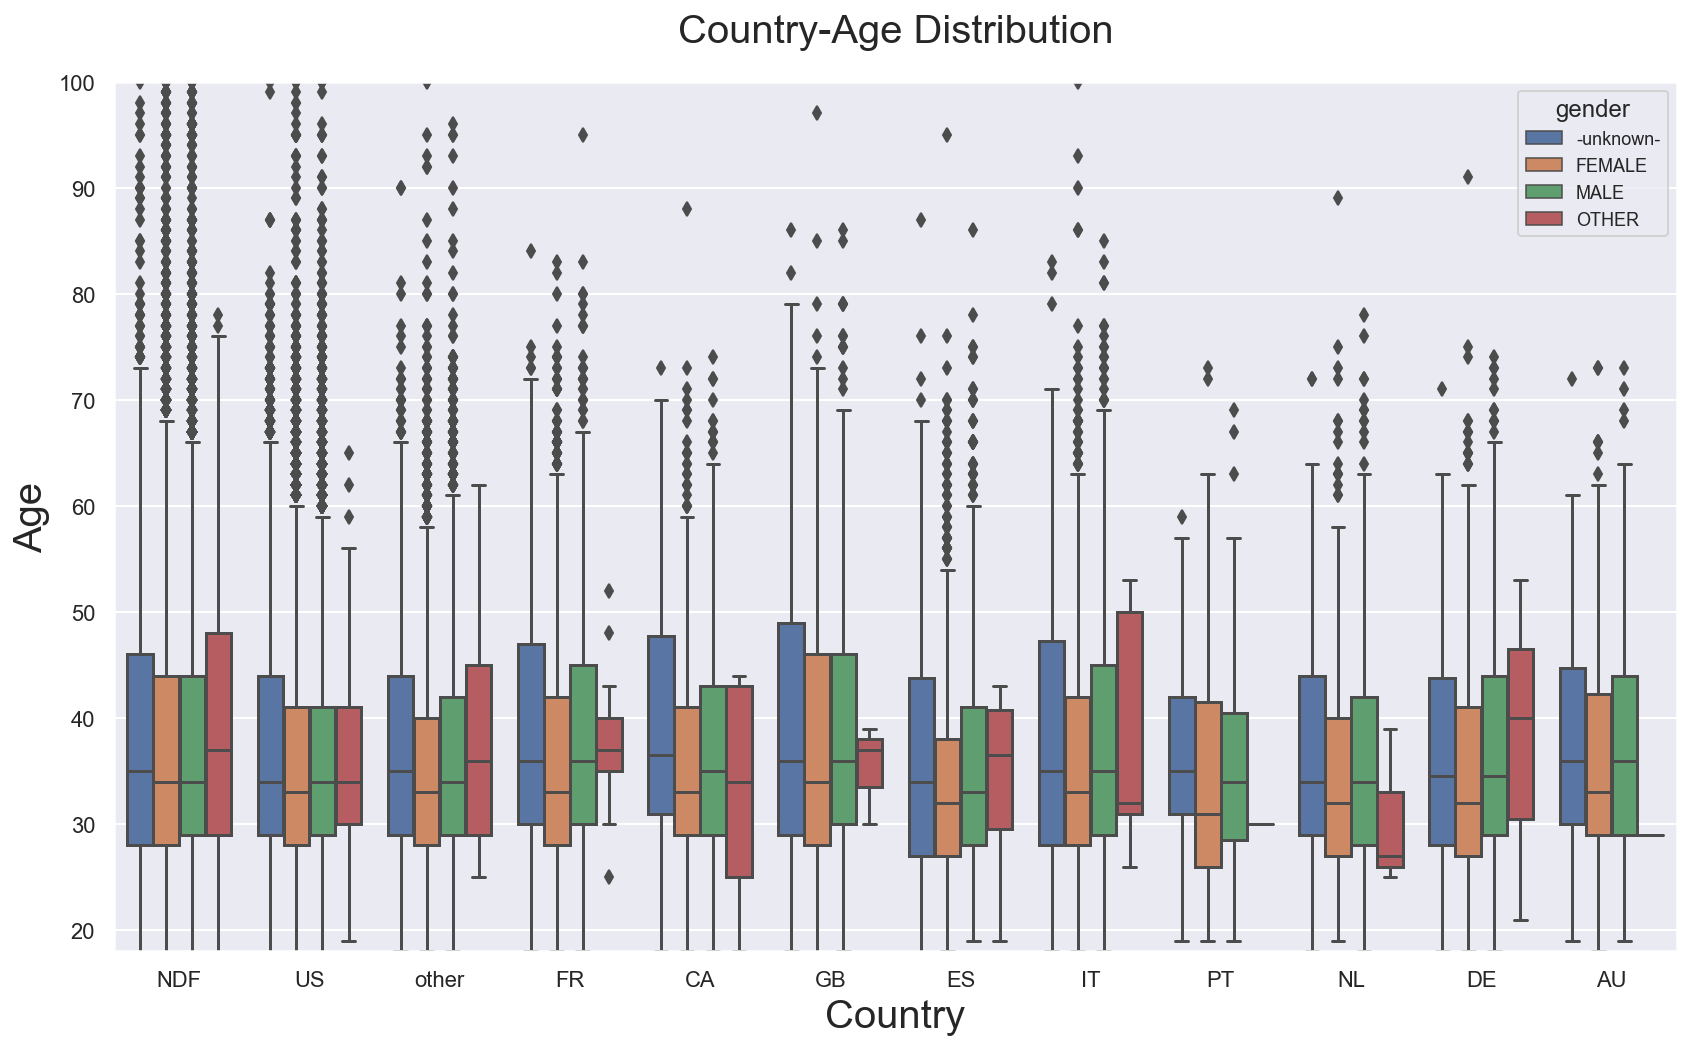

In [51]:
# 연령대 대비 목적지 국가와 성별의 관계 분포
plt.figure(figsize=[14,8])
sns.boxplot(data=df_all,y='age',x='country_destination',hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution', fontsize=20, pad=20);

In [61]:
labels = df_train.country_destination.values
labels

array(['NDF', 'NDF', 'US', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

In [57]:
# 라벨 분리 
x = df_train.drop(['country_destination'], axis=1)
y = df_train['country_destination']

In [58]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                   random_state=13)
np.unique(y_train, return_counts=True)

(array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
        'other'], dtype=object),
 array([  437,  1166,   859,  1788,  4060,  1874,  2276, 99568,   628,
          179, 49867,  8058]))

In [49]:
# train 데이터 중 country_destination 컬럼삭제
df_train = df_train.drop(["country_destination"], axis=1)

In [54]:
# dfWork = pd.concat((df_train, df_test), axis=0, ignore_index=True)
# dfWork = dfWork.drop(['id', 'date_first_booking'], axis=1)
# # 결측치 -1 채우기 
# dfWork = dfWork.fillna(-1)

In [51]:
# Feature 엔지니어링 

# 'date_account_created'에 -를 기준으로 자르고
# dac = np.vstack(dfWork.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)

#  자른 것을 year - 0 / month - 1 / day - 2로 나누고
# dfWork['dac_year'] = dac[:,0]
# dfWork['dac_month'] = dac[:,1]
# dfWork['dac_day'] = dac[:,2]

#  원래 있던 'date_account_created' 컬럼제거
# dfWork = dfWork.drop(['date_account_created'], axis=1)

In [52]:
# 'timestamp_first_active'에 각 숫자 순서기준으로 자르고
# tfa = np.vstack(dfWork.timestamp_first_active.astype(str).\
#                 apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)

# 자른 것을 year - 0 / month - 1 / day - 2로 나누고
# dfWork['tfa_year'] = tfa[:,0]
# dfWork['tfa_month'] = tfa[:,1]
# dfWork['tfa_day'] = tfa[:,2]

# 원래 있던 'timestamp_first_active' 컬럼제거
# dfWork = dfWork.drop(['timestamp_first_active'], axis=1)

In [55]:
# 확인 
# dfWork.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2010-06-28,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [56]:
# pd.get_dummies(dfWork, columns={"gender", "signup_method", "affiliate_provider", "signup_app", "first_device_type"})

,date_account_created,timestamp_first_active,age,signup_flow,language,affiliate_channel,first_affiliate_tracked,first_browser,signup_app_Android,signup_app_Moweb,...,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER
0,2010-06-28,20090319043255,-1.0,0,en,direct,untracked,Chrome,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2011-05-25,20090523174809,38.0,0,en,seo,untracked,Chrome,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2010-09-28,20090609231247,56.0,3,en,direct,untracked,IE,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2011-12-05,20091031060129,42.0,0,en,direct,untracked,Firefox,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2010-09-14,20091208061105,41.0,0,en,direct,untracked,Chrome,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,2014-09-30,20140930235232,31.0,0,en,direct,untracked,IE,0,0,...,0,0,0,0,0,0,1,0,0,0
275543,2014-09-30,20140930235306,-1.0,23,ko,direct,untracked,-unknown-,1,0,...,0,0,0,0,0,0,1,0,0,0
275544,2014-09-30,20140930235408,-1.0,0,de,direct,linked,Firefox,0,0,...,0,0,0,0,0,0,1,0,0,0
275545,2014-09-30,20140930235430,-1.0,0,en,sem-brand,omg,Safari,0,0,...,0,0,0,0,0,0,1,0,0,0


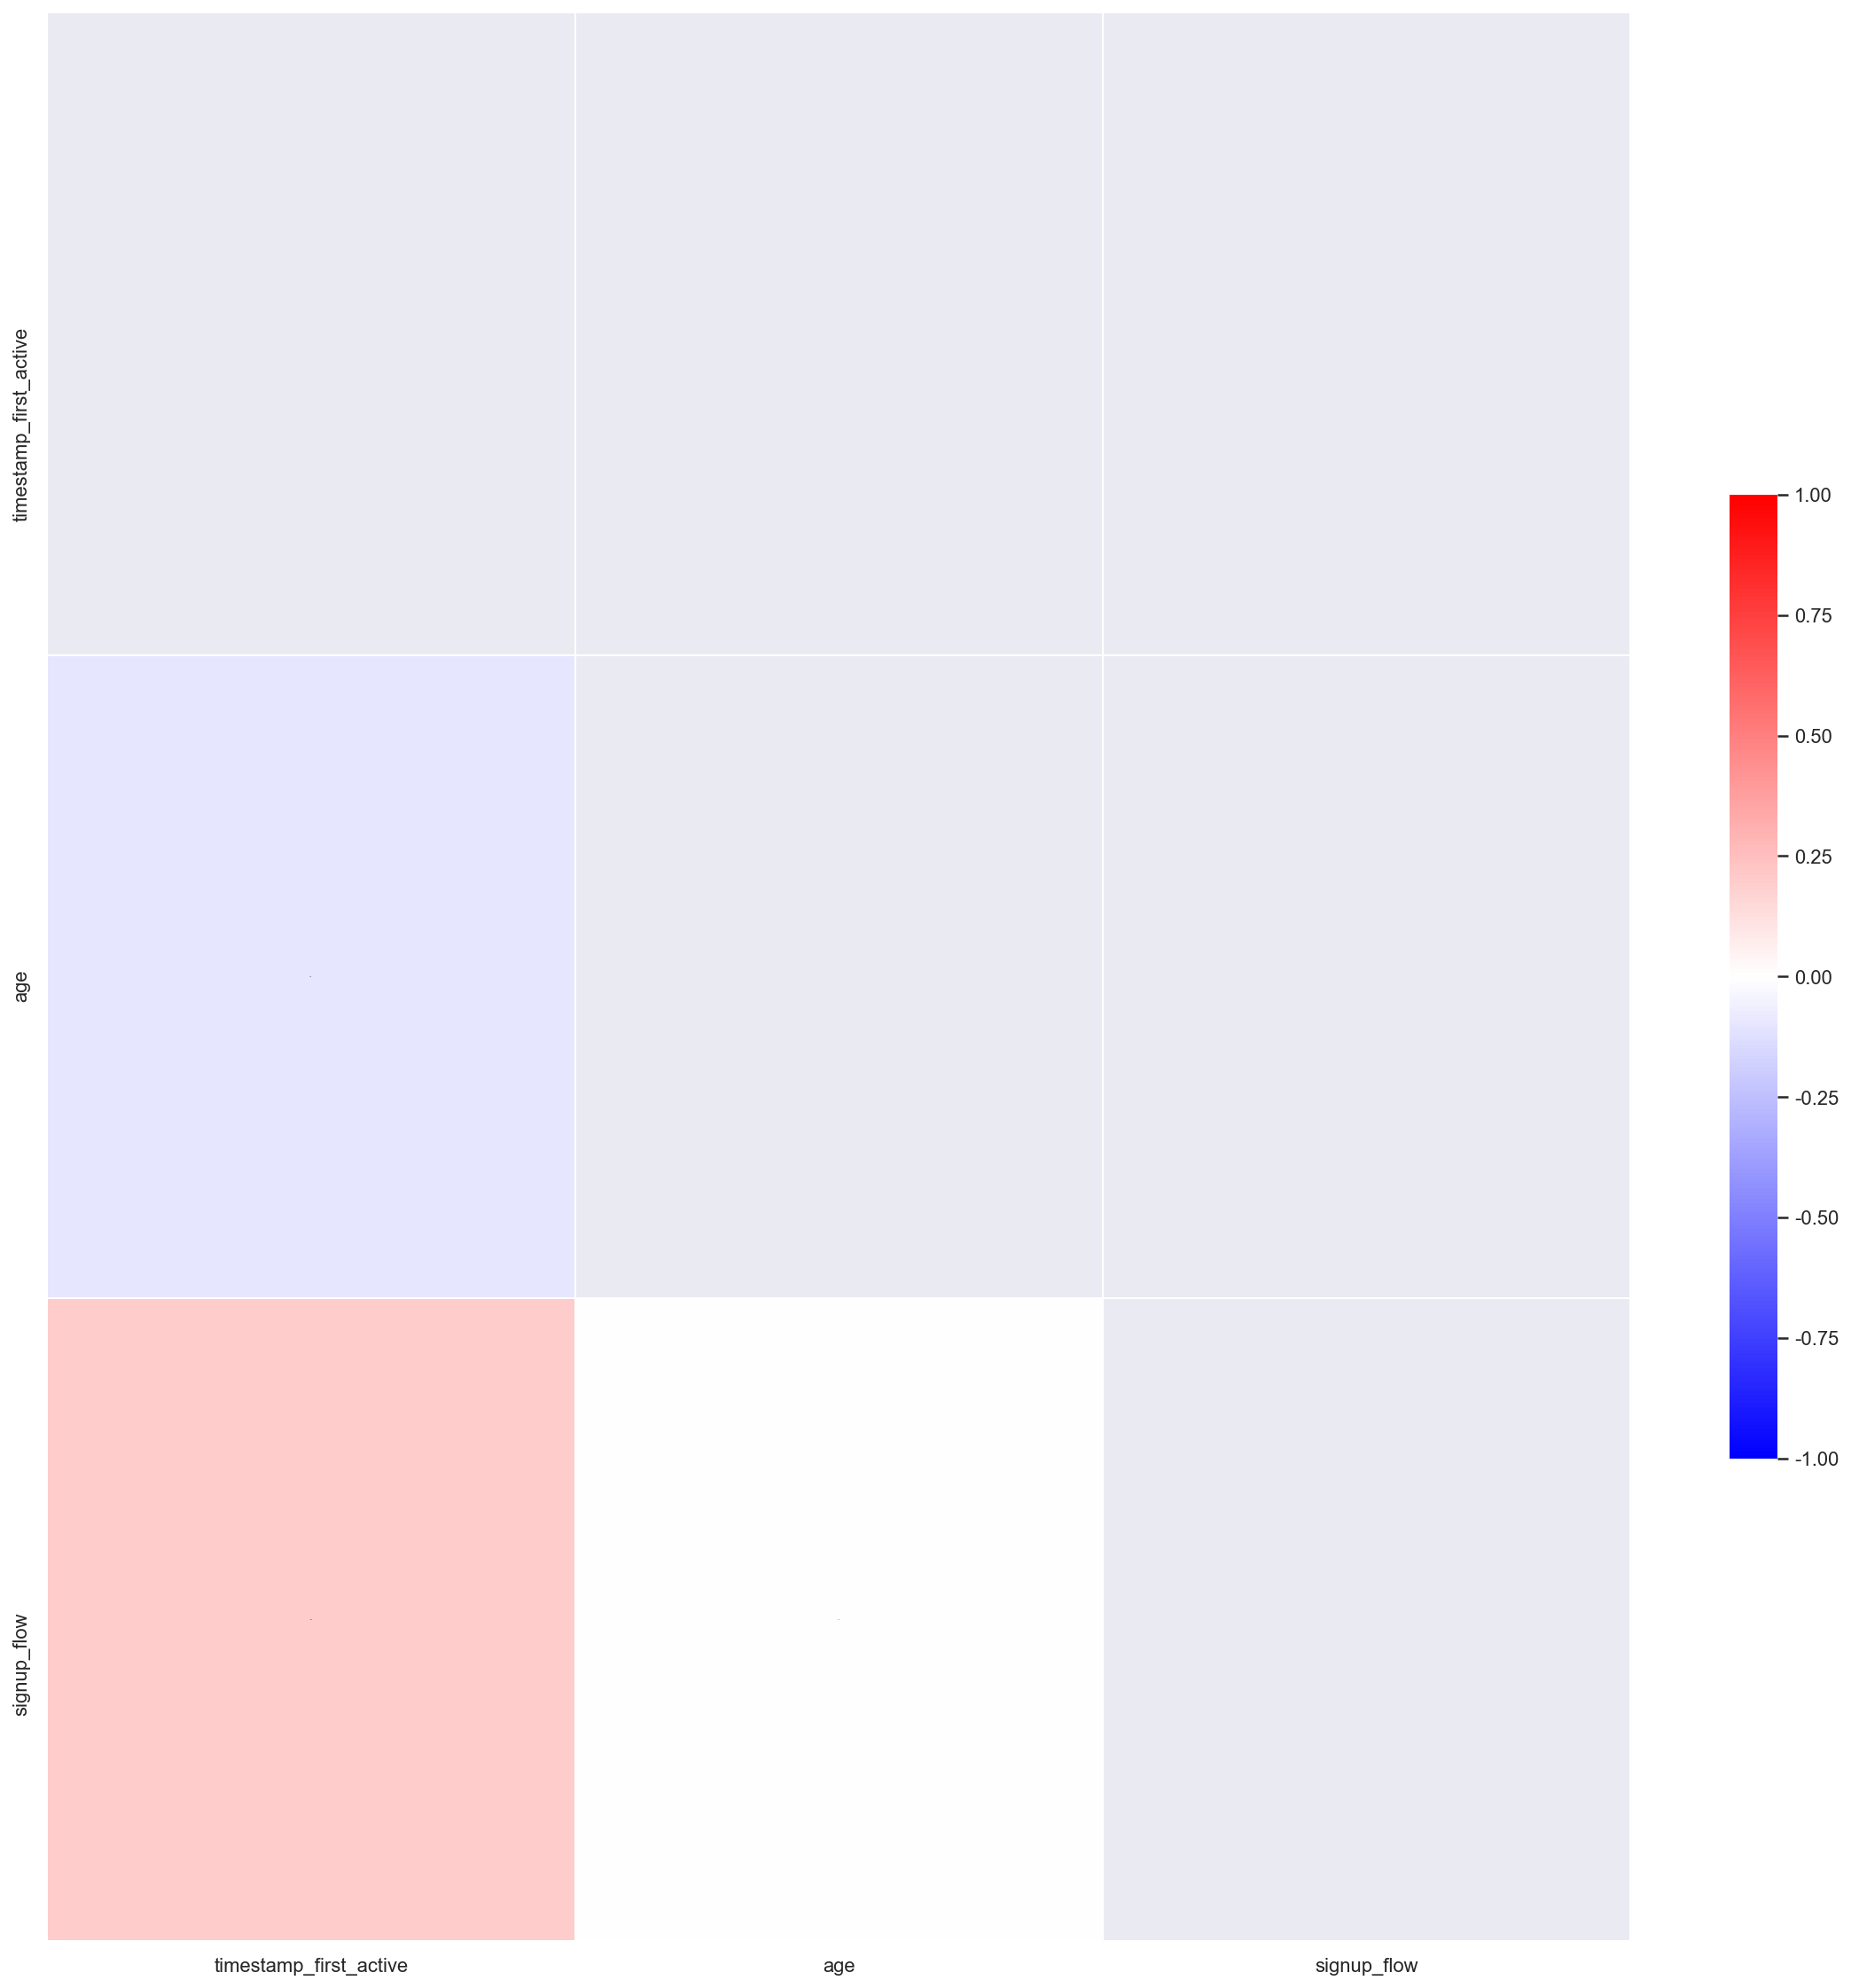

In [57]:
# 주요 변수들로 히트맵
# df = dfWork.corr().round(1)

# fig, ax = plt.subplots(figsize=(20,20))

# mask = np.zeros_like(df, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(df, 
#             cmap = 'bwr', 
#             annot = True,   
#             mask=mask,     
#             linewidths=.5,  
#             cbar_kws={"shrink": .5},
#             vmin = -1,vmax = 1   
#            )  
# plt.show()